In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_075_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3086158, 828)
(3086158, 8)
validation
(415168, 828)
(415168, 8)
test
(419234, 828)
(419234, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/309 [..............................] - ETA: 9:46 - loss: 2.3852 - STD: 0.0766 - MAE: 0.2188

  4/309 [..............................] - ETA: 6s - loss: 2.1995 - STD: 0.0464 - MAE: 0.2184  

  7/309 [..............................] - ETA: 6s - loss: 2.1610 - STD: 0.0418 - MAE: 0.2185

 10/309 [..............................] - ETA: 6s - loss: 2.1460 - STD: 0.0407 - MAE: 0.2185

 13/309 [>.............................] - ETA: 6s - loss: 2.1319 - STD: 0.0365 - MAE: 0.2185

 16/309 [>.............................] - ETA: 6s - loss: 2.1219 - STD: 0.0330 - MAE: 0.2184

 19/309 [>.............................] - ETA: 6s - loss: 2.1163 - STD: 0.0312 - MAE: 0.2184

 22/309 [=>............................] - ETA: 6s - loss: 2.1114 - STD: 0.0294 - MAE: 0.2184

 25/309 [=>............................] - ETA: 6s - loss: 2.1066 - STD: 0.0276 - MAE: 0.2184

 28/309 [=>............................] - ETA: 6s - loss: 2.1025 - STD: 0.0262 - MAE: 0.2184

 31/309 [==>...........................] - ETA: 6s - loss: 2.0988 - STD: 0.0252 - MAE: 0.2184

 34/309 [==>...........................] - ETA: 6s - loss: 2.0948 - STD: 0.0243 - MAE: 0.2183

 37/309 [==>...........................] - ETA: 6s - loss: 2.0899 - STD: 0.0237 - MAE: 0.2182

 40/309 [==>...........................] - ETA: 6s - loss: 2.0843 - STD: 0.0235 - MAE: 0.2180

 43/309 [===>..........................] - ETA: 6s - loss: 2.0777 - STD: 0.0240 - MAE: 0.2178

 46/309 [===>..........................] - ETA: 5s - loss: 2.0701 - STD: 0.0250 - MAE: 0.2175

 49/309 [===>..........................] - ETA: 5s - loss: 2.0617 - STD: 0.0265 - MAE: 0.2172

 52/309 [====>.........................] - ETA: 5s - loss: 2.0525 - STD: 0.0284 - MAE: 0.2167

 55/309 [====>.........................] - ETA: 5s - loss: 2.0430 - STD: 0.0305 - MAE: 0.2163

 58/309 [====>.........................] - ETA: 5s - loss: 2.0333 - STD: 0.0325 - MAE: 0.2158

 61/309 [====>.........................] - ETA: 5s - loss: 2.0231 - STD: 0.0346 - MAE: 0.2153

 64/309 [=====>........................] - ETA: 5s - loss: 2.0128 - STD: 0.0365 - MAE: 0.2148

 67/309 [=====>........................] - ETA: 5s - loss: 2.0020 - STD: 0.0384 - MAE: 0.2142

 69/309 [=====>........................] - ETA: 8s - loss: 1.9961 - STD: 0.0397 - MAE: 0.2139

 72/309 [=====>........................] - ETA: 8s - loss: 1.9848 - STD: 0.0416 - MAE: 0.2133

 75/309 [======>.......................] - ETA: 8s - loss: 1.9731 - STD: 0.0435 - MAE: 0.2127

 78/309 [======>.......................] - ETA: 7s - loss: 1.9608 - STD: 0.0455 - MAE: 0.2121

 81/309 [======>.......................] - ETA: 7s - loss: 1.9481 - STD: 0.0476 - MAE: 0.2113

 84/309 [=======>......................] - ETA: 7s - loss: 1.9354 - STD: 0.0498 - MAE: 0.2106

 87/309 [=======>......................] - ETA: 7s - loss: 1.9228 - STD: 0.0521 - MAE: 0.2098

 90/309 [=======>......................] - ETA: 7s - loss: 1.9108 - STD: 0.0543 - MAE: 0.2091

 93/309 [========>.....................] - ETA: 7s - loss: 1.8991 - STD: 0.0566 - MAE: 0.2083

 96/309 [========>.....................] - ETA: 6s - loss: 1.8876 - STD: 0.0588 - MAE: 0.2076

 99/309 [========>.....................] - ETA: 6s - loss: 1.8766 - STD: 0.0609 - MAE: 0.2068

102/309 [========>.....................] - ETA: 6s - loss: 1.8658 - STD: 0.0629 - MAE: 0.2061

105/309 [=========>....................] - ETA: 6s - loss: 1.8551 - STD: 0.0649 - MAE: 0.2054

108/309 [=========>....................] - ETA: 6s - loss: 1.8451 - STD: 0.0668 - MAE: 0.2047

111/309 [=========>....................] - ETA: 6s - loss: 1.8352 - STD: 0.0686 - MAE: 0.2041

114/309 [==========>...................] - ETA: 6s - loss: 1.8255 - STD: 0.0704 - MAE: 0.2034

117/309 [==========>...................] - ETA: 5s - loss: 1.8162 - STD: 0.0722 - MAE: 0.2028

120/309 [==========>...................] - ETA: 5s - loss: 1.8069 - STD: 0.0738 - MAE: 0.2021

123/309 [==========>...................] - ETA: 5s - loss: 1.7982 - STD: 0.0754 - MAE: 0.2015

126/309 [===========>..................] - ETA: 5s - loss: 1.7897 - STD: 0.0770 - MAE: 0.2009

129/309 [===========>..................] - ETA: 5s - loss: 1.7812 - STD: 0.0784 - MAE: 0.2004

132/309 [===========>..................] - ETA: 5s - loss: 1.7733 - STD: 0.0799 - MAE: 0.1998

135/309 [============>.................] - ETA: 5s - loss: 1.7654 - STD: 0.0813 - MAE: 0.1993

138/309 [============>.................] - ETA: 5s - loss: 1.7578 - STD: 0.0826 - MAE: 0.1987

141/309 [============>.................] - ETA: 4s - loss: 1.7505 - STD: 0.0839 - MAE: 0.1982

144/309 [============>.................] - ETA: 4s - loss: 1.7433 - STD: 0.0852 - MAE: 0.1977

147/309 [=============>................] - ETA: 4s - loss: 1.7362 - STD: 0.0865 - MAE: 0.1972

150/309 [=============>................] - ETA: 4s - loss: 1.7292 - STD: 0.0877 - MAE: 0.1967

153/309 [=============>................] - ETA: 4s - loss: 1.7223 - STD: 0.0889 - MAE: 0.1962

156/309 [==============>...............] - ETA: 4s - loss: 1.7156 - STD: 0.0901 - MAE: 0.1957

159/309 [==============>...............] - ETA: 4s - loss: 1.7093 - STD: 0.0912 - MAE: 0.1952

162/309 [==============>...............] - ETA: 4s - loss: 1.7032 - STD: 0.0924 - MAE: 0.1948

165/309 [===============>..............] - ETA: 4s - loss: 1.6969 - STD: 0.0935 - MAE: 0.1943

168/309 [===============>..............] - ETA: 3s - loss: 1.6913 - STD: 0.0945 - MAE: 0.1939

171/309 [===============>..............] - ETA: 3s - loss: 1.6856 - STD: 0.0956 - MAE: 0.1935

174/309 [===============>..............] - ETA: 3s - loss: 1.6799 - STD: 0.0966 - MAE: 0.1930

177/309 [================>.............] - ETA: 3s - loss: 1.6744 - STD: 0.0976 - MAE: 0.1926

180/309 [================>.............] - ETA: 3s - loss: 1.6690 - STD: 0.0986 - MAE: 0.1922

183/309 [================>.............] - ETA: 3s - loss: 1.6637 - STD: 0.0995 - MAE: 0.1918

186/309 [=================>............] - ETA: 3s - loss: 1.6584 - STD: 0.1004 - MAE: 0.1914

189/309 [=================>............] - ETA: 3s - loss: 1.6533 - STD: 0.1013 - MAE: 0.1910

192/309 [=================>............] - ETA: 3s - loss: 1.6482 - STD: 0.1022 - MAE: 0.1906

195/309 [=================>............] - ETA: 3s - loss: 1.6432 - STD: 0.1031 - MAE: 0.1902

198/309 [==================>...........] - ETA: 3s - loss: 1.6384 - STD: 0.1039 - MAE: 0.1899

201/309 [==================>...........] - ETA: 2s - loss: 1.6338 - STD: 0.1047 - MAE: 0.1895

204/309 [==================>...........] - ETA: 2s - loss: 1.6292 - STD: 0.1055 - MAE: 0.1892

207/309 [===================>..........] - ETA: 2s - loss: 1.6246 - STD: 0.1064 - MAE: 0.1888

210/309 [===================>..........] - ETA: 2s - loss: 1.6202 - STD: 0.1071 - MAE: 0.1885

213/309 [===================>..........] - ETA: 2s - loss: 1.6160 - STD: 0.1079 - MAE: 0.1881

216/309 [===================>..........] - ETA: 2s - loss: 1.6116 - STD: 0.1087 - MAE: 0.1878

219/309 [====================>.........] - ETA: 2s - loss: 1.6077 - STD: 0.1094 - MAE: 0.1875

222/309 [====================>.........] - ETA: 2s - loss: 1.6037 - STD: 0.1101 - MAE: 0.1871

225/309 [====================>.........] - ETA: 2s - loss: 1.5998 - STD: 0.1109 - MAE: 0.1868

228/309 [=====================>........] - ETA: 2s - loss: 1.5960 - STD: 0.1116 - MAE: 0.1865

231/309 [=====================>........] - ETA: 2s - loss: 1.5922 - STD: 0.1122 - MAE: 0.1862

234/309 [=====================>........] - ETA: 2s - loss: 1.5886 - STD: 0.1129 - MAE: 0.1859

237/309 [======================>.......] - ETA: 1s - loss: 1.5849 - STD: 0.1135 - MAE: 0.1856

240/309 [======================>.......] - ETA: 1s - loss: 1.5813 - STD: 0.1142 - MAE: 0.1853

243/309 [======================>.......] - ETA: 1s - loss: 1.5778 - STD: 0.1148 - MAE: 0.1851

246/309 [======================>.......] - ETA: 1s - loss: 1.5742 - STD: 0.1154 - MAE: 0.1848

249/309 [=======================>......] - ETA: 1s - loss: 1.5708 - STD: 0.1160 - MAE: 0.1845

252/309 [=======================>......] - ETA: 1s - loss: 1.5673 - STD: 0.1166 - MAE: 0.1843

255/309 [=======================>......] - ETA: 1s - loss: 1.5639 - STD: 0.1172 - MAE: 0.1840

258/309 [========================>.....] - ETA: 1s - loss: 1.5606 - STD: 0.1177 - MAE: 0.1837

261/309 [========================>.....] - ETA: 1s - loss: 1.5573 - STD: 0.1183 - MAE: 0.1835

264/309 [========================>.....] - ETA: 1s - loss: 1.5539 - STD: 0.1188 - MAE: 0.1832

267/309 [========================>.....] - ETA: 1s - loss: 1.5507 - STD: 0.1194 - MAE: 0.1829

270/309 [=========================>....] - ETA: 1s - loss: 1.5477 - STD: 0.1200 - MAE: 0.1827

273/309 [=========================>....] - ETA: 0s - loss: 1.5446 - STD: 0.1205 - MAE: 0.1824

276/309 [=========================>....] - ETA: 0s - loss: 1.5415 - STD: 0.1210 - MAE: 0.1822

279/309 [==========================>...] - ETA: 0s - loss: 1.5391 - STD: 0.1215 - MAE: 0.1820

282/309 [==========================>...] - ETA: 0s - loss: 1.5364 - STD: 0.1220 - MAE: 0.1818

285/309 [==========================>...] - ETA: 0s - loss: 1.5336 - STD: 0.1225 - MAE: 0.1815

288/309 [==========================>...] - ETA: 0s - loss: 1.5308 - STD: 0.1230 - MAE: 0.1813

291/309 [===========================>..] - ETA: 0s - loss: 1.5279 - STD: 0.1235 - MAE: 0.1811

294/309 [===========================>..] - ETA: 0s - loss: 1.5251 - STD: 0.1240 - MAE: 0.1808

297/309 [===========================>..] - ETA: 0s - loss: 1.5223 - STD: 0.1245 - MAE: 0.1806

300/309 [============================>.] - ETA: 0s - loss: 1.5196 - STD: 0.1249 - MAE: 0.1804

303/309 [============================>.] - ETA: 0s - loss: 1.5169 - STD: 0.1254 - MAE: 0.1802

306/309 [============================>.] - ETA: 0s - loss: 1.5144 - STD: 0.1258 - MAE: 0.1800

309/309 [==============================] - ETA: 0s - loss: 1.5118 - STD: 0.1262 - MAE: 0.1798

309/309 [==============================] - 11s 30ms/step - loss: 1.5118 - STD: 0.1262 - MAE: 0.1798 - val_loss: 1.3008 - val_STD: 0.1643 - val_MAE: 0.1623


Epoch 2/10000


  1/309 [..............................] - ETA: 14s - loss: 1.2193 - STD: 0.1712 - MAE: 0.1568

  4/309 [..............................] - ETA: 7s - loss: 1.2296 - STD: 0.1725 - MAE: 0.1569 

  7/309 [..............................] - ETA: 6s - loss: 1.2349 - STD: 0.1727 - MAE: 0.1571

 10/309 [..............................] - ETA: 6s - loss: 1.2341 - STD: 0.1727 - MAE: 0.1571

 13/309 [>.............................] - ETA: 6s - loss: 1.2332 - STD: 0.1728 - MAE: 0.1571

 16/309 [>.............................] - ETA: 6s - loss: 1.2339 - STD: 0.1726 - MAE: 0.1572

 19/309 [>.............................] - ETA: 6s - loss: 1.2354 - STD: 0.1728 - MAE: 0.1572

 22/309 [=>............................] - ETA: 6s - loss: 1.2348 - STD: 0.1729 - MAE: 0.1572

 25/309 [=>............................] - ETA: 6s - loss: 1.2353 - STD: 0.1729 - MAE: 0.1572

 28/309 [=>............................] - ETA: 6s - loss: 1.2374 - STD: 0.1730 - MAE: 0.1572

 31/309 [==>...........................] - ETA: 6s - loss: 1.2364 - STD: 0.1732 - MAE: 0.1571

 34/309 [==>...........................] - ETA: 6s - loss: 1.2351 - STD: 0.1733 - MAE: 0.1570

 37/309 [==>...........................] - ETA: 6s - loss: 1.2333 - STD: 0.1734 - MAE: 0.1569

 40/309 [==>...........................] - ETA: 6s - loss: 1.2327 - STD: 0.1736 - MAE: 0.1568

 43/309 [===>..........................] - ETA: 6s - loss: 1.2319 - STD: 0.1737 - MAE: 0.1567

 46/309 [===>..........................] - ETA: 5s - loss: 1.2311 - STD: 0.1737 - MAE: 0.1566

 49/309 [===>..........................] - ETA: 5s - loss: 1.2302 - STD: 0.1739 - MAE: 0.1565

 52/309 [====>.........................] - ETA: 5s - loss: 1.2290 - STD: 0.1740 - MAE: 0.1564

 55/309 [====>.........................] - ETA: 5s - loss: 1.2282 - STD: 0.1741 - MAE: 0.1563

 58/309 [====>.........................] - ETA: 5s - loss: 1.2293 - STD: 0.1742 - MAE: 0.1564

 61/309 [====>.........................] - ETA: 5s - loss: 1.2297 - STD: 0.1744 - MAE: 0.1563

 64/309 [=====>........................] - ETA: 5s - loss: 1.2299 - STD: 0.1746 - MAE: 0.1563

 67/309 [=====>........................] - ETA: 5s - loss: 1.2300 - STD: 0.1747 - MAE: 0.1562

 70/309 [=====>........................] - ETA: 5s - loss: 1.2299 - STD: 0.1747 - MAE: 0.1562

 73/309 [======>.......................] - ETA: 5s - loss: 1.2295 - STD: 0.1748 - MAE: 0.1562

 76/309 [======>.......................] - ETA: 5s - loss: 1.2288 - STD: 0.1748 - MAE: 0.1561

 79/309 [======>.......................] - ETA: 5s - loss: 1.2281 - STD: 0.1749 - MAE: 0.1561

 82/309 [======>.......................] - ETA: 5s - loss: 1.2274 - STD: 0.1750 - MAE: 0.1560

 85/309 [=======>......................] - ETA: 5s - loss: 1.2264 - STD: 0.1751 - MAE: 0.1559

 88/309 [=======>......................] - ETA: 5s - loss: 1.2252 - STD: 0.1751 - MAE: 0.1558

 91/309 [=======>......................] - ETA: 4s - loss: 1.2243 - STD: 0.1752 - MAE: 0.1558

 94/309 [========>.....................] - ETA: 4s - loss: 1.2234 - STD: 0.1753 - MAE: 0.1557

 97/309 [========>.....................] - ETA: 4s - loss: 1.2228 - STD: 0.1754 - MAE: 0.1556

100/309 [========>.....................] - ETA: 4s - loss: 1.2219 - STD: 0.1755 - MAE: 0.1556

103/309 [=========>....................] - ETA: 4s - loss: 1.2212 - STD: 0.1756 - MAE: 0.1555

106/309 [=========>....................] - ETA: 4s - loss: 1.2207 - STD: 0.1757 - MAE: 0.1554

109/309 [=========>....................] - ETA: 4s - loss: 1.2205 - STD: 0.1758 - MAE: 0.1554

112/309 [=========>....................] - ETA: 4s - loss: 1.2202 - STD: 0.1760 - MAE: 0.1553

115/309 [==========>...................] - ETA: 4s - loss: 1.2195 - STD: 0.1761 - MAE: 0.1552

118/309 [==========>...................] - ETA: 4s - loss: 1.2191 - STD: 0.1762 - MAE: 0.1552

121/309 [==========>...................] - ETA: 4s - loss: 1.2186 - STD: 0.1762 - MAE: 0.1551

124/309 [===========>..................] - ETA: 4s - loss: 1.2181 - STD: 0.1763 - MAE: 0.1551

127/309 [===========>..................] - ETA: 4s - loss: 1.2171 - STD: 0.1764 - MAE: 0.1550

130/309 [===========>..................] - ETA: 4s - loss: 1.2164 - STD: 0.1765 - MAE: 0.1549

133/309 [===========>..................] - ETA: 4s - loss: 1.2155 - STD: 0.1766 - MAE: 0.1549

136/309 [============>.................] - ETA: 3s - loss: 1.2147 - STD: 0.1767 - MAE: 0.1548

139/309 [============>.................] - ETA: 3s - loss: 1.2139 - STD: 0.1768 - MAE: 0.1547

142/309 [============>.................] - ETA: 3s - loss: 1.2132 - STD: 0.1769 - MAE: 0.1546

145/309 [=============>................] - ETA: 3s - loss: 1.2126 - STD: 0.1770 - MAE: 0.1546

148/309 [=============>................] - ETA: 3s - loss: 1.2120 - STD: 0.1770 - MAE: 0.1545

151/309 [=============>................] - ETA: 3s - loss: 1.2113 - STD: 0.1771 - MAE: 0.1545

154/309 [=============>................] - ETA: 3s - loss: 1.2112 - STD: 0.1772 - MAE: 0.1544

157/309 [==============>...............] - ETA: 3s - loss: 1.2106 - STD: 0.1773 - MAE: 0.1544

160/309 [==============>...............] - ETA: 3s - loss: 1.2098 - STD: 0.1774 - MAE: 0.1543

163/309 [==============>...............] - ETA: 3s - loss: 1.2091 - STD: 0.1775 - MAE: 0.1542

166/309 [===============>..............] - ETA: 3s - loss: 1.2084 - STD: 0.1775 - MAE: 0.1542

169/309 [===============>..............] - ETA: 3s - loss: 1.2078 - STD: 0.1776 - MAE: 0.1541

172/309 [===============>..............] - ETA: 3s - loss: 1.2072 - STD: 0.1777 - MAE: 0.1540

175/309 [===============>..............] - ETA: 3s - loss: 1.2064 - STD: 0.1778 - MAE: 0.1540

178/309 [================>.............] - ETA: 3s - loss: 1.2058 - STD: 0.1779 - MAE: 0.1539

181/309 [================>.............] - ETA: 2s - loss: 1.2052 - STD: 0.1780 - MAE: 0.1538

184/309 [================>.............] - ETA: 2s - loss: 1.2044 - STD: 0.1781 - MAE: 0.1538

187/309 [=================>............] - ETA: 2s - loss: 1.2037 - STD: 0.1782 - MAE: 0.1537

190/309 [=================>............] - ETA: 2s - loss: 1.2031 - STD: 0.1782 - MAE: 0.1536

193/309 [=================>............] - ETA: 2s - loss: 1.2024 - STD: 0.1783 - MAE: 0.1536

196/309 [==================>...........] - ETA: 2s - loss: 1.2020 - STD: 0.1784 - MAE: 0.1535

199/309 [==================>...........] - ETA: 2s - loss: 1.2013 - STD: 0.1785 - MAE: 0.1534

202/309 [==================>...........] - ETA: 2s - loss: 1.2007 - STD: 0.1786 - MAE: 0.1534

205/309 [==================>...........] - ETA: 2s - loss: 1.2004 - STD: 0.1787 - MAE: 0.1533

208/309 [===================>..........] - ETA: 2s - loss: 1.1999 - STD: 0.1788 - MAE: 0.1533

211/309 [===================>..........] - ETA: 2s - loss: 1.1996 - STD: 0.1789 - MAE: 0.1532

214/309 [===================>..........] - ETA: 2s - loss: 1.1989 - STD: 0.1790 - MAE: 0.1532

217/309 [====================>.........] - ETA: 2s - loss: 1.1985 - STD: 0.1791 - MAE: 0.1531

220/309 [====================>.........] - ETA: 2s - loss: 1.1979 - STD: 0.1792 - MAE: 0.1530

223/309 [====================>.........] - ETA: 1s - loss: 1.1975 - STD: 0.1792 - MAE: 0.1530

226/309 [====================>.........] - ETA: 1s - loss: 1.1970 - STD: 0.1793 - MAE: 0.1529

229/309 [=====================>........] - ETA: 1s - loss: 1.1965 - STD: 0.1794 - MAE: 0.1529

232/309 [=====================>........] - ETA: 1s - loss: 1.1961 - STD: 0.1794 - MAE: 0.1528

235/309 [=====================>........] - ETA: 1s - loss: 1.1955 - STD: 0.1795 - MAE: 0.1528

238/309 [======================>.......] - ETA: 1s - loss: 1.1950 - STD: 0.1796 - MAE: 0.1527

241/309 [======================>.......] - ETA: 1s - loss: 1.1945 - STD: 0.1797 - MAE: 0.1527

244/309 [======================>.......] - ETA: 1s - loss: 1.1939 - STD: 0.1797 - MAE: 0.1526

247/309 [======================>.......] - ETA: 1s - loss: 1.1935 - STD: 0.1798 - MAE: 0.1526

250/309 [=======================>......] - ETA: 1s - loss: 1.1931 - STD: 0.1799 - MAE: 0.1525

253/309 [=======================>......] - ETA: 1s - loss: 1.1925 - STD: 0.1800 - MAE: 0.1525

256/309 [=======================>......] - ETA: 1s - loss: 1.1920 - STD: 0.1801 - MAE: 0.1524

259/309 [========================>.....] - ETA: 1s - loss: 1.1916 - STD: 0.1801 - MAE: 0.1524

262/309 [========================>.....] - ETA: 1s - loss: 1.1911 - STD: 0.1802 - MAE: 0.1523

265/309 [========================>.....] - ETA: 1s - loss: 1.1908 - STD: 0.1803 - MAE: 0.1523

268/309 [=========================>....] - ETA: 0s - loss: 1.1902 - STD: 0.1803 - MAE: 0.1522

271/309 [=========================>....] - ETA: 0s - loss: 1.1896 - STD: 0.1804 - MAE: 0.1521

274/309 [=========================>....] - ETA: 0s - loss: 1.1890 - STD: 0.1805 - MAE: 0.1521

277/309 [=========================>....] - ETA: 0s - loss: 1.1884 - STD: 0.1806 - MAE: 0.1520

280/309 [==========================>...] - ETA: 0s - loss: 1.1877 - STD: 0.1806 - MAE: 0.1520

283/309 [==========================>...] - ETA: 0s - loss: 1.1871 - STD: 0.1807 - MAE: 0.1519

286/309 [==========================>...] - ETA: 0s - loss: 1.1865 - STD: 0.1808 - MAE: 0.1518

289/309 [===========================>..] - ETA: 0s - loss: 1.1860 - STD: 0.1809 - MAE: 0.1518

292/309 [===========================>..] - ETA: 0s - loss: 1.1855 - STD: 0.1809 - MAE: 0.1517

295/309 [===========================>..] - ETA: 0s - loss: 1.1849 - STD: 0.1810 - MAE: 0.1517

298/309 [===========================>..] - ETA: 0s - loss: 1.1843 - STD: 0.1811 - MAE: 0.1516

301/309 [============================>.] - ETA: 0s - loss: 1.1837 - STD: 0.1812 - MAE: 0.1516

304/309 [============================>.] - ETA: 0s - loss: 1.1831 - STD: 0.1813 - MAE: 0.1515

307/309 [============================>.] - ETA: 0s - loss: 1.1828 - STD: 0.1813 - MAE: 0.1515

309/309 [==============================] - 8s 25ms/step - loss: 1.1824 - STD: 0.1814 - MAE: 0.1514 - val_loss: 1.2474 - val_STD: 0.1837 - val_MAE: 0.1537


Epoch 3/10000


  1/309 [..............................] - ETA: 15s - loss: 1.1358 - STD: 0.1906 - MAE: 0.1452

  4/309 [..............................] - ETA: 7s - loss: 1.1750 - STD: 0.1902 - MAE: 0.1476 

  7/309 [..............................] - ETA: 6s - loss: 1.1616 - STD: 0.1905 - MAE: 0.1468

 10/309 [..............................] - ETA: 6s - loss: 1.1560 - STD: 0.1901 - MAE: 0.1467

 13/309 [>.............................] - ETA: 6s - loss: 1.1500 - STD: 0.1897 - MAE: 0.1466

 16/309 [>.............................] - ETA: 6s - loss: 1.1475 - STD: 0.1894 - MAE: 0.1466

 19/309 [>.............................] - ETA: 6s - loss: 1.1443 - STD: 0.1892 - MAE: 0.1465

 22/309 [=>............................] - ETA: 6s - loss: 1.1403 - STD: 0.1894 - MAE: 0.1462

 25/309 [=>............................] - ETA: 6s - loss: 1.1381 - STD: 0.1894 - MAE: 0.1461

 28/309 [=>............................] - ETA: 6s - loss: 1.1362 - STD: 0.1894 - MAE: 0.1460

 31/309 [==>...........................] - ETA: 6s - loss: 1.1345 - STD: 0.1894 - MAE: 0.1459

 34/309 [==>...........................] - ETA: 6s - loss: 1.1339 - STD: 0.1894 - MAE: 0.1459

 37/309 [==>...........................] - ETA: 6s - loss: 1.1337 - STD: 0.1895 - MAE: 0.1459

 40/309 [==>...........................] - ETA: 6s - loss: 1.1326 - STD: 0.1896 - MAE: 0.1457

 43/309 [===>..........................] - ETA: 6s - loss: 1.1321 - STD: 0.1897 - MAE: 0.1457

 46/309 [===>..........................] - ETA: 6s - loss: 1.1328 - STD: 0.1897 - MAE: 0.1457

 49/309 [===>..........................] - ETA: 5s - loss: 1.1327 - STD: 0.1897 - MAE: 0.1457

 52/309 [====>.........................] - ETA: 5s - loss: 1.1338 - STD: 0.1897 - MAE: 0.1458

 55/309 [====>.........................] - ETA: 5s - loss: 1.1339 - STD: 0.1898 - MAE: 0.1458

 58/309 [====>.........................] - ETA: 5s - loss: 1.1338 - STD: 0.1898 - MAE: 0.1457

 61/309 [====>.........................] - ETA: 5s - loss: 1.1334 - STD: 0.1899 - MAE: 0.1457

 64/309 [=====>........................] - ETA: 5s - loss: 1.1330 - STD: 0.1899 - MAE: 0.1456

 67/309 [=====>........................] - ETA: 5s - loss: 1.1325 - STD: 0.1900 - MAE: 0.1456

 70/309 [=====>........................] - ETA: 5s - loss: 1.1314 - STD: 0.1900 - MAE: 0.1455

 73/309 [======>.......................] - ETA: 5s - loss: 1.1309 - STD: 0.1901 - MAE: 0.1455

 76/309 [======>.......................] - ETA: 5s - loss: 1.1303 - STD: 0.1901 - MAE: 0.1454

 79/309 [======>.......................] - ETA: 5s - loss: 1.1295 - STD: 0.1902 - MAE: 0.1453

 82/309 [======>.......................] - ETA: 5s - loss: 1.1286 - STD: 0.1902 - MAE: 0.1453

 85/309 [=======>......................] - ETA: 5s - loss: 1.1278 - STD: 0.1903 - MAE: 0.1452

 88/309 [=======>......................] - ETA: 5s - loss: 1.1269 - STD: 0.1903 - MAE: 0.1452

 91/309 [=======>......................] - ETA: 4s - loss: 1.1263 - STD: 0.1904 - MAE: 0.1451

 94/309 [========>.....................] - ETA: 4s - loss: 1.1255 - STD: 0.1905 - MAE: 0.1450

 97/309 [========>.....................] - ETA: 4s - loss: 1.1253 - STD: 0.1905 - MAE: 0.1450

100/309 [========>.....................] - ETA: 4s - loss: 1.1251 - STD: 0.1906 - MAE: 0.1449

103/309 [=========>....................] - ETA: 4s - loss: 1.1246 - STD: 0.1906 - MAE: 0.1449

106/309 [=========>....................] - ETA: 4s - loss: 1.1238 - STD: 0.1907 - MAE: 0.1448

109/309 [=========>....................] - ETA: 4s - loss: 1.1235 - STD: 0.1907 - MAE: 0.1448

112/309 [=========>....................] - ETA: 4s - loss: 1.1229 - STD: 0.1908 - MAE: 0.1447

115/309 [==========>...................] - ETA: 4s - loss: 1.1223 - STD: 0.1908 - MAE: 0.1447

118/309 [==========>...................] - ETA: 4s - loss: 1.1217 - STD: 0.1909 - MAE: 0.1446

121/309 [==========>...................] - ETA: 4s - loss: 1.1212 - STD: 0.1909 - MAE: 0.1446

124/309 [===========>..................] - ETA: 4s - loss: 1.1205 - STD: 0.1910 - MAE: 0.1445

127/309 [===========>..................] - ETA: 4s - loss: 1.1198 - STD: 0.1911 - MAE: 0.1445

130/309 [===========>..................] - ETA: 4s - loss: 1.1193 - STD: 0.1911 - MAE: 0.1444

133/309 [===========>..................] - ETA: 4s - loss: 1.1185 - STD: 0.1912 - MAE: 0.1444

136/309 [============>.................] - ETA: 3s - loss: 1.1180 - STD: 0.1912 - MAE: 0.1443

139/309 [============>.................] - ETA: 3s - loss: 1.1174 - STD: 0.1913 - MAE: 0.1443

142/309 [============>.................] - ETA: 3s - loss: 1.1169 - STD: 0.1913 - MAE: 0.1442

145/309 [=============>................] - ETA: 3s - loss: 1.1164 - STD: 0.1914 - MAE: 0.1442

148/309 [=============>................] - ETA: 3s - loss: 1.1158 - STD: 0.1914 - MAE: 0.1441

151/309 [=============>................] - ETA: 3s - loss: 1.1151 - STD: 0.1915 - MAE: 0.1440

154/309 [=============>................] - ETA: 3s - loss: 1.1150 - STD: 0.1916 - MAE: 0.1440

157/309 [==============>...............] - ETA: 3s - loss: 1.1151 - STD: 0.1917 - MAE: 0.1440

160/309 [==============>...............] - ETA: 3s - loss: 1.1148 - STD: 0.1917 - MAE: 0.1439

163/309 [==============>...............] - ETA: 3s - loss: 1.1144 - STD: 0.1918 - MAE: 0.1439

166/309 [===============>..............] - ETA: 3s - loss: 1.1141 - STD: 0.1919 - MAE: 0.1438

169/309 [===============>..............] - ETA: 3s - loss: 1.1136 - STD: 0.1919 - MAE: 0.1438

172/309 [===============>..............] - ETA: 3s - loss: 1.1129 - STD: 0.1920 - MAE: 0.1437

175/309 [===============>..............] - ETA: 3s - loss: 1.1125 - STD: 0.1920 - MAE: 0.1437

178/309 [================>.............] - ETA: 2s - loss: 1.1122 - STD: 0.1920 - MAE: 0.1437

181/309 [================>.............] - ETA: 2s - loss: 1.1119 - STD: 0.1921 - MAE: 0.1436

184/309 [================>.............] - ETA: 2s - loss: 1.1113 - STD: 0.1921 - MAE: 0.1436

187/309 [=================>............] - ETA: 2s - loss: 1.1108 - STD: 0.1922 - MAE: 0.1435

190/309 [=================>............] - ETA: 2s - loss: 1.1103 - STD: 0.1923 - MAE: 0.1435

193/309 [=================>............] - ETA: 2s - loss: 1.1099 - STD: 0.1923 - MAE: 0.1434

196/309 [==================>...........] - ETA: 2s - loss: 1.1095 - STD: 0.1924 - MAE: 0.1434

199/309 [==================>...........] - ETA: 2s - loss: 1.1091 - STD: 0.1924 - MAE: 0.1434

202/309 [==================>...........] - ETA: 2s - loss: 1.1088 - STD: 0.1925 - MAE: 0.1433

205/309 [==================>...........] - ETA: 2s - loss: 1.1084 - STD: 0.1925 - MAE: 0.1433

208/309 [===================>..........] - ETA: 2s - loss: 1.1081 - STD: 0.1926 - MAE: 0.1432

211/309 [===================>..........] - ETA: 2s - loss: 1.1081 - STD: 0.1927 - MAE: 0.1432

214/309 [===================>..........] - ETA: 2s - loss: 1.1080 - STD: 0.1927 - MAE: 0.1432

217/309 [====================>.........] - ETA: 2s - loss: 1.1076 - STD: 0.1928 - MAE: 0.1431

220/309 [====================>.........] - ETA: 2s - loss: 1.1072 - STD: 0.1928 - MAE: 0.1431

223/309 [====================>.........] - ETA: 1s - loss: 1.1067 - STD: 0.1928 - MAE: 0.1430

226/309 [====================>.........] - ETA: 1s - loss: 1.1065 - STD: 0.1929 - MAE: 0.1430

229/309 [=====================>........] - ETA: 1s - loss: 1.1061 - STD: 0.1929 - MAE: 0.1430

232/309 [=====================>........] - ETA: 1s - loss: 1.1056 - STD: 0.1930 - MAE: 0.1429

235/309 [=====================>........] - ETA: 1s - loss: 1.1052 - STD: 0.1930 - MAE: 0.1429

238/309 [======================>.......] - ETA: 1s - loss: 1.1049 - STD: 0.1931 - MAE: 0.1428

241/309 [======================>.......] - ETA: 1s - loss: 1.1043 - STD: 0.1931 - MAE: 0.1428

244/309 [======================>.......] - ETA: 1s - loss: 1.1039 - STD: 0.1932 - MAE: 0.1427

247/309 [======================>.......] - ETA: 1s - loss: 1.1033 - STD: 0.1932 - MAE: 0.1427

250/309 [=======================>......] - ETA: 1s - loss: 1.1030 - STD: 0.1933 - MAE: 0.1427

253/309 [=======================>......] - ETA: 1s - loss: 1.1025 - STD: 0.1933 - MAE: 0.1426

256/309 [=======================>......] - ETA: 1s - loss: 1.1020 - STD: 0.1934 - MAE: 0.1426

259/309 [========================>.....] - ETA: 1s - loss: 1.1016 - STD: 0.1934 - MAE: 0.1425

262/309 [========================>.....] - ETA: 1s - loss: 1.1011 - STD: 0.1935 - MAE: 0.1425

265/309 [========================>.....] - ETA: 1s - loss: 1.1007 - STD: 0.1935 - MAE: 0.1424

268/309 [=========================>....] - ETA: 0s - loss: 1.1003 - STD: 0.1936 - MAE: 0.1424

271/309 [=========================>....] - ETA: 0s - loss: 1.0998 - STD: 0.1937 - MAE: 0.1423

274/309 [=========================>....] - ETA: 0s - loss: 1.0993 - STD: 0.1937 - MAE: 0.1423

277/309 [=========================>....] - ETA: 0s - loss: 1.0988 - STD: 0.1938 - MAE: 0.1422

280/309 [==========================>...] - ETA: 0s - loss: 1.0984 - STD: 0.1938 - MAE: 0.1422

283/309 [==========================>...] - ETA: 0s - loss: 1.0980 - STD: 0.1939 - MAE: 0.1421

286/309 [==========================>...] - ETA: 0s - loss: 1.0977 - STD: 0.1940 - MAE: 0.1421

289/309 [===========================>..] - ETA: 0s - loss: 1.0973 - STD: 0.1940 - MAE: 0.1421

292/309 [===========================>..] - ETA: 0s - loss: 1.0969 - STD: 0.1941 - MAE: 0.1420

295/309 [===========================>..] - ETA: 0s - loss: 1.0966 - STD: 0.1941 - MAE: 0.1420

298/309 [===========================>..] - ETA: 0s - loss: 1.0963 - STD: 0.1942 - MAE: 0.1419

301/309 [============================>.] - ETA: 0s - loss: 1.0960 - STD: 0.1942 - MAE: 0.1419

304/309 [============================>.] - ETA: 0s - loss: 1.0955 - STD: 0.1943 - MAE: 0.1418

307/309 [============================>.] - ETA: 0s - loss: 1.0951 - STD: 0.1943 - MAE: 0.1418

309/309 [==============================] - 8s 25ms/step - loss: 1.0948 - STD: 0.1944 - MAE: 0.1418 - val_loss: 1.1856 - val_STD: 0.1944 - val_MAE: 0.1469


Epoch 4/10000


  1/309 [..............................] - ETA: 15s - loss: 1.0661 - STD: 0.1985 - MAE: 0.1385

  4/309 [..............................] - ETA: 7s - loss: 1.0584 - STD: 0.1999 - MAE: 0.1376 

  7/309 [..............................] - ETA: 6s - loss: 1.0593 - STD: 0.1998 - MAE: 0.1376

 10/309 [..............................] - ETA: 6s - loss: 1.0614 - STD: 0.1997 - MAE: 0.1378

 13/309 [>.............................] - ETA: 6s - loss: 1.0577 - STD: 0.1996 - MAE: 0.1376

 16/309 [>.............................] - ETA: 6s - loss: 1.0554 - STD: 0.1997 - MAE: 0.1374

 19/309 [>.............................] - ETA: 6s - loss: 1.0532 - STD: 0.1997 - MAE: 0.1374

 22/309 [=>............................] - ETA: 6s - loss: 1.0515 - STD: 0.1997 - MAE: 0.1372

 25/309 [=>............................] - ETA: 6s - loss: 1.0530 - STD: 0.1998 - MAE: 0.1373

 28/309 [=>............................] - ETA: 6s - loss: 1.0533 - STD: 0.1999 - MAE: 0.1372

 31/309 [==>...........................] - ETA: 6s - loss: 1.0535 - STD: 0.2000 - MAE: 0.1372

 34/309 [==>...........................] - ETA: 6s - loss: 1.0553 - STD: 0.2001 - MAE: 0.1373

 37/309 [==>...........................] - ETA: 6s - loss: 1.0541 - STD: 0.2001 - MAE: 0.1372

 40/309 [==>...........................] - ETA: 6s - loss: 1.0534 - STD: 0.2002 - MAE: 0.1371

 43/309 [===>..........................] - ETA: 6s - loss: 1.0539 - STD: 0.2003 - MAE: 0.1371

 46/309 [===>..........................] - ETA: 5s - loss: 1.0533 - STD: 0.2004 - MAE: 0.1370

 49/309 [===>..........................] - ETA: 5s - loss: 1.0533 - STD: 0.2004 - MAE: 0.1370

 52/309 [====>.........................] - ETA: 5s - loss: 1.0524 - STD: 0.2004 - MAE: 0.1370

 55/309 [====>.........................] - ETA: 5s - loss: 1.0515 - STD: 0.2004 - MAE: 0.1369

 58/309 [====>.........................] - ETA: 5s - loss: 1.0506 - STD: 0.2003 - MAE: 0.1369

 61/309 [====>.........................] - ETA: 5s - loss: 1.0495 - STD: 0.2004 - MAE: 0.1368

 64/309 [=====>........................] - ETA: 5s - loss: 1.0490 - STD: 0.2004 - MAE: 0.1368

 67/309 [=====>........................] - ETA: 5s - loss: 1.0484 - STD: 0.2004 - MAE: 0.1367

 70/309 [=====>........................] - ETA: 5s - loss: 1.0480 - STD: 0.2005 - MAE: 0.1367

 73/309 [======>.......................] - ETA: 5s - loss: 1.0488 - STD: 0.2005 - MAE: 0.1367

 76/309 [======>.......................] - ETA: 5s - loss: 1.0484 - STD: 0.2006 - MAE: 0.1367

 79/309 [======>.......................] - ETA: 5s - loss: 1.0480 - STD: 0.2006 - MAE: 0.1366

 82/309 [======>.......................] - ETA: 5s - loss: 1.0482 - STD: 0.2007 - MAE: 0.1366

 85/309 [=======>......................] - ETA: 5s - loss: 1.0477 - STD: 0.2008 - MAE: 0.1365

 88/309 [=======>......................] - ETA: 5s - loss: 1.0474 - STD: 0.2009 - MAE: 0.1365

 91/309 [=======>......................] - ETA: 4s - loss: 1.0469 - STD: 0.2009 - MAE: 0.1364

 94/309 [========>.....................] - ETA: 4s - loss: 1.0469 - STD: 0.2010 - MAE: 0.1364

 97/309 [========>.....................] - ETA: 4s - loss: 1.0469 - STD: 0.2010 - MAE: 0.1364

100/309 [========>.....................] - ETA: 4s - loss: 1.0469 - STD: 0.2010 - MAE: 0.1364

103/309 [=========>....................] - ETA: 4s - loss: 1.0470 - STD: 0.2010 - MAE: 0.1364

106/309 [=========>....................] - ETA: 4s - loss: 1.0466 - STD: 0.2011 - MAE: 0.1363

109/309 [=========>....................] - ETA: 4s - loss: 1.0465 - STD: 0.2011 - MAE: 0.1363

112/309 [=========>....................] - ETA: 4s - loss: 1.0463 - STD: 0.2011 - MAE: 0.1363

115/309 [==========>...................] - ETA: 4s - loss: 1.0460 - STD: 0.2012 - MAE: 0.1363

118/309 [==========>...................] - ETA: 4s - loss: 1.0458 - STD: 0.2012 - MAE: 0.1362

121/309 [==========>...................] - ETA: 4s - loss: 1.0455 - STD: 0.2012 - MAE: 0.1362

124/309 [===========>..................] - ETA: 4s - loss: 1.0450 - STD: 0.2013 - MAE: 0.1361

127/309 [===========>..................] - ETA: 4s - loss: 1.0448 - STD: 0.2013 - MAE: 0.1361

130/309 [===========>..................] - ETA: 4s - loss: 1.0445 - STD: 0.2014 - MAE: 0.1361

133/309 [===========>..................] - ETA: 4s - loss: 1.0440 - STD: 0.2014 - MAE: 0.1360

136/309 [============>.................] - ETA: 3s - loss: 1.0436 - STD: 0.2015 - MAE: 0.1360

139/309 [============>.................] - ETA: 3s - loss: 1.0433 - STD: 0.2015 - MAE: 0.1360

142/309 [============>.................] - ETA: 3s - loss: 1.0432 - STD: 0.2015 - MAE: 0.1359

145/309 [=============>................] - ETA: 3s - loss: 1.0429 - STD: 0.2016 - MAE: 0.1359

148/309 [=============>................] - ETA: 3s - loss: 1.0426 - STD: 0.2016 - MAE: 0.1359

151/309 [=============>................] - ETA: 3s - loss: 1.0423 - STD: 0.2017 - MAE: 0.1358

154/309 [=============>................] - ETA: 3s - loss: 1.0418 - STD: 0.2017 - MAE: 0.1358

157/309 [==============>...............] - ETA: 3s - loss: 1.0413 - STD: 0.2017 - MAE: 0.1358

160/309 [==============>...............] - ETA: 3s - loss: 1.0408 - STD: 0.2018 - MAE: 0.1357

163/309 [==============>...............] - ETA: 3s - loss: 1.0403 - STD: 0.2018 - MAE: 0.1357

166/309 [===============>..............] - ETA: 3s - loss: 1.0398 - STD: 0.2019 - MAE: 0.1356

169/309 [===============>..............] - ETA: 3s - loss: 1.0392 - STD: 0.2019 - MAE: 0.1356

172/309 [===============>..............] - ETA: 3s - loss: 1.0391 - STD: 0.2020 - MAE: 0.1355

175/309 [===============>..............] - ETA: 3s - loss: 1.0385 - STD: 0.2020 - MAE: 0.1355

178/309 [================>.............] - ETA: 2s - loss: 1.0382 - STD: 0.2021 - MAE: 0.1354

181/309 [================>.............] - ETA: 2s - loss: 1.0382 - STD: 0.2021 - MAE: 0.1354

184/309 [================>.............] - ETA: 2s - loss: 1.0378 - STD: 0.2021 - MAE: 0.1354

187/309 [=================>............] - ETA: 2s - loss: 1.0374 - STD: 0.2022 - MAE: 0.1354

190/309 [=================>............] - ETA: 2s - loss: 1.0370 - STD: 0.2022 - MAE: 0.1353

193/309 [=================>............] - ETA: 2s - loss: 1.0365 - STD: 0.2023 - MAE: 0.1353

196/309 [==================>...........] - ETA: 2s - loss: 1.0361 - STD: 0.2023 - MAE: 0.1352

199/309 [==================>...........] - ETA: 2s - loss: 1.0357 - STD: 0.2024 - MAE: 0.1352

202/309 [==================>...........] - ETA: 2s - loss: 1.0354 - STD: 0.2024 - MAE: 0.1351

205/309 [==================>...........] - ETA: 2s - loss: 1.0350 - STD: 0.2025 - MAE: 0.1351

208/309 [===================>..........] - ETA: 2s - loss: 1.0347 - STD: 0.2025 - MAE: 0.1351

211/309 [===================>..........] - ETA: 2s - loss: 1.0343 - STD: 0.2025 - MAE: 0.1350

214/309 [===================>..........] - ETA: 2s - loss: 1.0339 - STD: 0.2026 - MAE: 0.1350

217/309 [====================>.........] - ETA: 2s - loss: 1.0336 - STD: 0.2026 - MAE: 0.1349

220/309 [====================>.........] - ETA: 2s - loss: 1.0335 - STD: 0.2027 - MAE: 0.1349

223/309 [====================>.........] - ETA: 1s - loss: 1.0332 - STD: 0.2027 - MAE: 0.1349

226/309 [====================>.........] - ETA: 1s - loss: 1.0328 - STD: 0.2028 - MAE: 0.1348

229/309 [=====================>........] - ETA: 1s - loss: 1.0325 - STD: 0.2028 - MAE: 0.1348

232/309 [=====================>........] - ETA: 1s - loss: 1.0322 - STD: 0.2029 - MAE: 0.1348

235/309 [=====================>........] - ETA: 1s - loss: 1.0318 - STD: 0.2029 - MAE: 0.1347

238/309 [======================>.......] - ETA: 1s - loss: 1.0314 - STD: 0.2030 - MAE: 0.1347

241/309 [======================>.......] - ETA: 1s - loss: 1.0311 - STD: 0.2030 - MAE: 0.1346

244/309 [======================>.......] - ETA: 1s - loss: 1.0309 - STD: 0.2030 - MAE: 0.1346

247/309 [======================>.......] - ETA: 1s - loss: 1.0306 - STD: 0.2031 - MAE: 0.1346

250/309 [=======================>......] - ETA: 1s - loss: 1.0304 - STD: 0.2031 - MAE: 0.1345

253/309 [=======================>......] - ETA: 1s - loss: 1.0299 - STD: 0.2032 - MAE: 0.1345

256/309 [=======================>......] - ETA: 1s - loss: 1.0296 - STD: 0.2032 - MAE: 0.1345

259/309 [========================>.....] - ETA: 1s - loss: 1.0293 - STD: 0.2033 - MAE: 0.1344

262/309 [========================>.....] - ETA: 1s - loss: 1.0290 - STD: 0.2033 - MAE: 0.1344

265/309 [========================>.....] - ETA: 1s - loss: 1.0285 - STD: 0.2033 - MAE: 0.1344

268/309 [=========================>....] - ETA: 0s - loss: 1.0281 - STD: 0.2034 - MAE: 0.1343

271/309 [=========================>....] - ETA: 0s - loss: 1.0276 - STD: 0.2034 - MAE: 0.1343

274/309 [=========================>....] - ETA: 0s - loss: 1.0274 - STD: 0.2035 - MAE: 0.1342

277/309 [=========================>....] - ETA: 0s - loss: 1.0271 - STD: 0.2035 - MAE: 0.1342

280/309 [==========================>...] - ETA: 0s - loss: 1.0268 - STD: 0.2036 - MAE: 0.1342

283/309 [==========================>...] - ETA: 0s - loss: 1.0264 - STD: 0.2036 - MAE: 0.1341

286/309 [==========================>...] - ETA: 0s - loss: 1.0263 - STD: 0.2036 - MAE: 0.1341

289/309 [===========================>..] - ETA: 0s - loss: 1.0259 - STD: 0.2037 - MAE: 0.1341

292/309 [===========================>..] - ETA: 0s - loss: 1.0255 - STD: 0.2037 - MAE: 0.1340

295/309 [===========================>..] - ETA: 0s - loss: 1.0253 - STD: 0.2038 - MAE: 0.1340

298/309 [===========================>..] - ETA: 0s - loss: 1.0249 - STD: 0.2038 - MAE: 0.1340

301/309 [============================>.] - ETA: 0s - loss: 1.0247 - STD: 0.2039 - MAE: 0.1339

304/309 [============================>.] - ETA: 0s - loss: 1.0244 - STD: 0.2039 - MAE: 0.1339

307/309 [============================>.] - ETA: 0s - loss: 1.0239 - STD: 0.2039 - MAE: 0.1338

309/309 [==============================] - 8s 25ms/step - loss: 1.0237 - STD: 0.2040 - MAE: 0.1338 - val_loss: 1.1244 - val_STD: 0.2049 - val_MAE: 0.1401


Epoch 5/10000


  1/309 [..............................] - ETA: 14s - loss: 1.0064 - STD: 0.2091 - MAE: 0.1307

  4/309 [..............................] - ETA: 6s - loss: 0.9931 - STD: 0.2085 - MAE: 0.1302 

  7/309 [..............................] - ETA: 6s - loss: 0.9886 - STD: 0.2087 - MAE: 0.1298

 10/309 [..............................] - ETA: 6s - loss: 0.9852 - STD: 0.2085 - MAE: 0.1297

 13/309 [>.............................] - ETA: 6s - loss: 0.9855 - STD: 0.2085 - MAE: 0.1297

 16/309 [>.............................] - ETA: 6s - loss: 0.9841 - STD: 0.2087 - MAE: 0.1296

 19/309 [>.............................] - ETA: 6s - loss: 0.9826 - STD: 0.2087 - MAE: 0.1295

 22/309 [=>............................] - ETA: 6s - loss: 0.9875 - STD: 0.2088 - MAE: 0.1297

 25/309 [=>............................] - ETA: 6s - loss: 0.9867 - STD: 0.2088 - MAE: 0.1297

 28/309 [=>............................] - ETA: 6s - loss: 0.9856 - STD: 0.2088 - MAE: 0.1296

 31/309 [==>...........................] - ETA: 6s - loss: 0.9883 - STD: 0.2088 - MAE: 0.1298

 34/309 [==>...........................] - ETA: 6s - loss: 0.9882 - STD: 0.2089 - MAE: 0.1297

 37/309 [==>...........................] - ETA: 6s - loss: 0.9891 - STD: 0.2090 - MAE: 0.1297

 40/309 [==>...........................] - ETA: 6s - loss: 0.9887 - STD: 0.2090 - MAE: 0.1297

 43/309 [===>..........................] - ETA: 6s - loss: 0.9895 - STD: 0.2090 - MAE: 0.1298

 46/309 [===>..........................] - ETA: 6s - loss: 0.9887 - STD: 0.2090 - MAE: 0.1297

 49/309 [===>..........................] - ETA: 5s - loss: 0.9881 - STD: 0.2091 - MAE: 0.1296

 52/309 [====>.........................] - ETA: 5s - loss: 0.9880 - STD: 0.2092 - MAE: 0.1296

 55/309 [====>.........................] - ETA: 5s - loss: 0.9878 - STD: 0.2092 - MAE: 0.1295

 58/309 [====>.........................] - ETA: 5s - loss: 0.9872 - STD: 0.2092 - MAE: 0.1295

 61/309 [====>.........................] - ETA: 5s - loss: 0.9869 - STD: 0.2092 - MAE: 0.1295

 64/309 [=====>........................] - ETA: 5s - loss: 0.9866 - STD: 0.2093 - MAE: 0.1294

 67/309 [=====>........................] - ETA: 5s - loss: 0.9862 - STD: 0.2093 - MAE: 0.1294

 70/309 [=====>........................] - ETA: 5s - loss: 0.9862 - STD: 0.2093 - MAE: 0.1294

 73/309 [======>.......................] - ETA: 5s - loss: 0.9865 - STD: 0.2093 - MAE: 0.1294

 76/309 [======>.......................] - ETA: 5s - loss: 0.9866 - STD: 0.2093 - MAE: 0.1294

 79/309 [======>.......................] - ETA: 5s - loss: 0.9865 - STD: 0.2093 - MAE: 0.1294

 82/309 [======>.......................] - ETA: 5s - loss: 0.9863 - STD: 0.2093 - MAE: 0.1294

 85/309 [=======>......................] - ETA: 5s - loss: 0.9859 - STD: 0.2093 - MAE: 0.1294

 88/309 [=======>......................] - ETA: 5s - loss: 0.9855 - STD: 0.2093 - MAE: 0.1293

 91/309 [=======>......................] - ETA: 4s - loss: 0.9850 - STD: 0.2094 - MAE: 0.1293

 94/309 [========>.....................] - ETA: 4s - loss: 0.9846 - STD: 0.2094 - MAE: 0.1293

 97/309 [========>.....................] - ETA: 4s - loss: 0.9849 - STD: 0.2094 - MAE: 0.1293

100/309 [========>.....................] - ETA: 4s - loss: 0.9843 - STD: 0.2094 - MAE: 0.1292

103/309 [=========>....................] - ETA: 4s - loss: 0.9846 - STD: 0.2094 - MAE: 0.1292

106/309 [=========>....................] - ETA: 4s - loss: 0.9848 - STD: 0.2095 - MAE: 0.1292

109/309 [=========>....................] - ETA: 4s - loss: 0.9850 - STD: 0.2095 - MAE: 0.1292

112/309 [=========>....................] - ETA: 4s - loss: 0.9846 - STD: 0.2096 - MAE: 0.1292

115/309 [==========>...................] - ETA: 4s - loss: 0.9842 - STD: 0.2096 - MAE: 0.1291

118/309 [==========>...................] - ETA: 4s - loss: 0.9840 - STD: 0.2096 - MAE: 0.1291

121/309 [==========>...................] - ETA: 4s - loss: 0.9835 - STD: 0.2097 - MAE: 0.1291

124/309 [===========>..................] - ETA: 4s - loss: 0.9832 - STD: 0.2097 - MAE: 0.1290

127/309 [===========>..................] - ETA: 4s - loss: 0.9830 - STD: 0.2098 - MAE: 0.1290

130/309 [===========>..................] - ETA: 4s - loss: 0.9832 - STD: 0.2098 - MAE: 0.1290

133/309 [===========>..................] - ETA: 4s - loss: 0.9830 - STD: 0.2099 - MAE: 0.1289

136/309 [============>.................] - ETA: 3s - loss: 0.9827 - STD: 0.2099 - MAE: 0.1289

139/309 [============>.................] - ETA: 3s - loss: 0.9826 - STD: 0.2099 - MAE: 0.1289

142/309 [============>.................] - ETA: 3s - loss: 0.9824 - STD: 0.2100 - MAE: 0.1289

145/309 [=============>................] - ETA: 3s - loss: 0.9822 - STD: 0.2100 - MAE: 0.1288

148/309 [=============>................] - ETA: 3s - loss: 0.9818 - STD: 0.2100 - MAE: 0.1288

151/309 [=============>................] - ETA: 3s - loss: 0.9816 - STD: 0.2100 - MAE: 0.1288

154/309 [=============>................] - ETA: 3s - loss: 0.9814 - STD: 0.2101 - MAE: 0.1288

157/309 [==============>...............] - ETA: 3s - loss: 0.9812 - STD: 0.2101 - MAE: 0.1287

160/309 [==============>...............] - ETA: 3s - loss: 0.9811 - STD: 0.2101 - MAE: 0.1287

163/309 [==============>...............] - ETA: 3s - loss: 0.9806 - STD: 0.2101 - MAE: 0.1287

166/309 [===============>..............] - ETA: 3s - loss: 0.9801 - STD: 0.2102 - MAE: 0.1286

169/309 [===============>..............] - ETA: 3s - loss: 0.9795 - STD: 0.2102 - MAE: 0.1286

172/309 [===============>..............] - ETA: 3s - loss: 0.9791 - STD: 0.2102 - MAE: 0.1286

175/309 [===============>..............] - ETA: 3s - loss: 0.9788 - STD: 0.2103 - MAE: 0.1285

178/309 [================>.............] - ETA: 2s - loss: 0.9783 - STD: 0.2103 - MAE: 0.1285

181/309 [================>.............] - ETA: 2s - loss: 0.9784 - STD: 0.2104 - MAE: 0.1285

184/309 [================>.............] - ETA: 2s - loss: 0.9780 - STD: 0.2104 - MAE: 0.1284

187/309 [=================>............] - ETA: 2s - loss: 0.9780 - STD: 0.2104 - MAE: 0.1284

190/309 [=================>............] - ETA: 2s - loss: 0.9778 - STD: 0.2105 - MAE: 0.1284

193/309 [=================>............] - ETA: 2s - loss: 0.9775 - STD: 0.2105 - MAE: 0.1284

196/309 [==================>...........] - ETA: 2s - loss: 0.9773 - STD: 0.2105 - MAE: 0.1283

199/309 [==================>...........] - ETA: 2s - loss: 0.9770 - STD: 0.2105 - MAE: 0.1283

202/309 [==================>...........] - ETA: 2s - loss: 0.9767 - STD: 0.2106 - MAE: 0.1283

205/309 [==================>...........] - ETA: 2s - loss: 0.9763 - STD: 0.2106 - MAE: 0.1282

208/309 [===================>..........] - ETA: 2s - loss: 0.9758 - STD: 0.2106 - MAE: 0.1282

211/309 [===================>..........] - ETA: 2s - loss: 0.9755 - STD: 0.2107 - MAE: 0.1282

214/309 [===================>..........] - ETA: 2s - loss: 0.9751 - STD: 0.2107 - MAE: 0.1281

217/309 [====================>.........] - ETA: 2s - loss: 0.9747 - STD: 0.2107 - MAE: 0.1281

220/309 [====================>.........] - ETA: 2s - loss: 0.9743 - STD: 0.2107 - MAE: 0.1281

223/309 [====================>.........] - ETA: 1s - loss: 0.9739 - STD: 0.2108 - MAE: 0.1280

226/309 [====================>.........] - ETA: 1s - loss: 0.9739 - STD: 0.2108 - MAE: 0.1280

229/309 [=====================>........] - ETA: 1s - loss: 0.9737 - STD: 0.2108 - MAE: 0.1280

232/309 [=====================>........] - ETA: 1s - loss: 0.9734 - STD: 0.2109 - MAE: 0.1279

235/309 [=====================>........] - ETA: 1s - loss: 0.9731 - STD: 0.2109 - MAE: 0.1279

238/309 [======================>.......] - ETA: 1s - loss: 0.9728 - STD: 0.2110 - MAE: 0.1279

241/309 [======================>.......] - ETA: 1s - loss: 0.9724 - STD: 0.2110 - MAE: 0.1278

244/309 [======================>.......] - ETA: 1s - loss: 0.9720 - STD: 0.2110 - MAE: 0.1278

247/309 [======================>.......] - ETA: 1s - loss: 0.9717 - STD: 0.2111 - MAE: 0.1278

250/309 [=======================>......] - ETA: 1s - loss: 0.9715 - STD: 0.2111 - MAE: 0.1277

253/309 [=======================>......] - ETA: 1s - loss: 0.9714 - STD: 0.2112 - MAE: 0.1277

256/309 [=======================>......] - ETA: 1s - loss: 0.9716 - STD: 0.2112 - MAE: 0.1277

259/309 [========================>.....] - ETA: 1s - loss: 0.9713 - STD: 0.2112 - MAE: 0.1277

262/309 [========================>.....] - ETA: 1s - loss: 0.9710 - STD: 0.2112 - MAE: 0.1276

265/309 [========================>.....] - ETA: 1s - loss: 0.9706 - STD: 0.2113 - MAE: 0.1276

268/309 [=========================>....] - ETA: 0s - loss: 0.9704 - STD: 0.2113 - MAE: 0.1276

271/309 [=========================>....] - ETA: 0s - loss: 0.9700 - STD: 0.2113 - MAE: 0.1275

274/309 [=========================>....] - ETA: 0s - loss: 0.9698 - STD: 0.2114 - MAE: 0.1275

277/309 [=========================>....] - ETA: 0s - loss: 0.9697 - STD: 0.2114 - MAE: 0.1275

280/309 [==========================>...] - ETA: 0s - loss: 0.9695 - STD: 0.2114 - MAE: 0.1275

283/309 [==========================>...] - ETA: 0s - loss: 0.9692 - STD: 0.2115 - MAE: 0.1274

286/309 [==========================>...] - ETA: 0s - loss: 0.9689 - STD: 0.2115 - MAE: 0.1274

289/309 [===========================>..] - ETA: 0s - loss: 0.9686 - STD: 0.2115 - MAE: 0.1274

292/309 [===========================>..] - ETA: 0s - loss: 0.9687 - STD: 0.2116 - MAE: 0.1274

295/309 [===========================>..] - ETA: 0s - loss: 0.9685 - STD: 0.2116 - MAE: 0.1274

298/309 [===========================>..] - ETA: 0s - loss: 0.9686 - STD: 0.2116 - MAE: 0.1273

301/309 [============================>.] - ETA: 0s - loss: 0.9687 - STD: 0.2116 - MAE: 0.1273

304/309 [============================>.] - ETA: 0s - loss: 0.9684 - STD: 0.2117 - MAE: 0.1273

307/309 [============================>.] - ETA: 0s - loss: 0.9681 - STD: 0.2117 - MAE: 0.1273

309/309 [==============================] - 8s 25ms/step - loss: 0.9679 - STD: 0.2117 - MAE: 0.1273 - val_loss: 1.1474 - val_STD: 0.2089 - val_MAE: 0.1397


Epoch 6/10000


  1/309 [..............................] - ETA: 16s - loss: 0.9286 - STD: 0.2155 - MAE: 0.1234

  4/309 [..............................] - ETA: 7s - loss: 0.9349 - STD: 0.2155 - MAE: 0.1237 

  7/309 [..............................] - ETA: 6s - loss: 0.9405 - STD: 0.2143 - MAE: 0.1244

 10/309 [..............................] - ETA: 6s - loss: 0.9377 - STD: 0.2142 - MAE: 0.1243

 13/309 [>.............................] - ETA: 6s - loss: 0.9384 - STD: 0.2140 - MAE: 0.1245

 16/309 [>.............................] - ETA: 6s - loss: 0.9377 - STD: 0.2141 - MAE: 0.1244

 19/309 [>.............................] - ETA: 6s - loss: 0.9376 - STD: 0.2140 - MAE: 0.1244

 22/309 [=>............................] - ETA: 6s - loss: 0.9367 - STD: 0.2142 - MAE: 0.1243

 25/309 [=>............................] - ETA: 6s - loss: 0.9384 - STD: 0.2145 - MAE: 0.1242

 28/309 [=>............................] - ETA: 6s - loss: 0.9380 - STD: 0.2146 - MAE: 0.1242

 31/309 [==>...........................] - ETA: 6s - loss: 0.9413 - STD: 0.2147 - MAE: 0.1243

 34/309 [==>...........................] - ETA: 6s - loss: 0.9418 - STD: 0.2148 - MAE: 0.1244

 37/309 [==>...........................] - ETA: 6s - loss: 0.9426 - STD: 0.2149 - MAE: 0.1243

 40/309 [==>...........................] - ETA: 6s - loss: 0.9421 - STD: 0.2150 - MAE: 0.1243

 43/309 [===>..........................] - ETA: 6s - loss: 0.9425 - STD: 0.2150 - MAE: 0.1243

 46/309 [===>..........................] - ETA: 5s - loss: 0.9426 - STD: 0.2151 - MAE: 0.1243

 49/309 [===>..........................] - ETA: 5s - loss: 0.9423 - STD: 0.2152 - MAE: 0.1242

 52/309 [====>.........................] - ETA: 5s - loss: 0.9420 - STD: 0.2153 - MAE: 0.1242

 55/309 [====>.........................] - ETA: 5s - loss: 0.9424 - STD: 0.2152 - MAE: 0.1242

 58/309 [====>.........................] - ETA: 5s - loss: 0.9433 - STD: 0.2153 - MAE: 0.1242

 61/309 [====>.........................] - ETA: 5s - loss: 0.9429 - STD: 0.2154 - MAE: 0.1242

 64/309 [=====>........................] - ETA: 5s - loss: 0.9427 - STD: 0.2153 - MAE: 0.1242

 67/309 [=====>........................] - ETA: 5s - loss: 0.9424 - STD: 0.2153 - MAE: 0.1242

 70/309 [=====>........................] - ETA: 5s - loss: 0.9427 - STD: 0.2153 - MAE: 0.1242

 73/309 [======>.......................] - ETA: 5s - loss: 0.9434 - STD: 0.2153 - MAE: 0.1242

 76/309 [======>.......................] - ETA: 5s - loss: 0.9433 - STD: 0.2153 - MAE: 0.1242

 79/309 [======>.......................] - ETA: 5s - loss: 0.9435 - STD: 0.2153 - MAE: 0.1242

 82/309 [======>.......................] - ETA: 5s - loss: 0.9435 - STD: 0.2154 - MAE: 0.1242

 85/309 [=======>......................] - ETA: 5s - loss: 0.9436 - STD: 0.2154 - MAE: 0.1242

 88/309 [=======>......................] - ETA: 4s - loss: 0.9442 - STD: 0.2154 - MAE: 0.1243

 91/309 [=======>......................] - ETA: 4s - loss: 0.9437 - STD: 0.2154 - MAE: 0.1242

 94/309 [========>.....................] - ETA: 4s - loss: 0.9436 - STD: 0.2155 - MAE: 0.1242

 97/309 [========>.....................] - ETA: 4s - loss: 0.9434 - STD: 0.2155 - MAE: 0.1242

100/309 [========>.....................] - ETA: 4s - loss: 0.9430 - STD: 0.2155 - MAE: 0.1241

103/309 [=========>....................] - ETA: 4s - loss: 0.9423 - STD: 0.2155 - MAE: 0.1241

106/309 [=========>....................] - ETA: 4s - loss: 0.9421 - STD: 0.2155 - MAE: 0.1241

109/309 [=========>....................] - ETA: 4s - loss: 0.9417 - STD: 0.2156 - MAE: 0.1240

112/309 [=========>....................] - ETA: 4s - loss: 0.9413 - STD: 0.2156 - MAE: 0.1240

115/309 [==========>...................] - ETA: 4s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1240

118/309 [==========>...................] - ETA: 4s - loss: 0.9405 - STD: 0.2156 - MAE: 0.1239

121/309 [==========>...................] - ETA: 4s - loss: 0.9399 - STD: 0.2156 - MAE: 0.1239

124/309 [===========>..................] - ETA: 4s - loss: 0.9395 - STD: 0.2156 - MAE: 0.1239

127/309 [===========>..................] - ETA: 4s - loss: 0.9397 - STD: 0.2157 - MAE: 0.1239

130/309 [===========>..................] - ETA: 4s - loss: 0.9393 - STD: 0.2157 - MAE: 0.1238

133/309 [===========>..................] - ETA: 3s - loss: 0.9389 - STD: 0.2157 - MAE: 0.1238

136/309 [============>.................] - ETA: 3s - loss: 0.9384 - STD: 0.2158 - MAE: 0.1237

139/309 [============>.................] - ETA: 3s - loss: 0.9380 - STD: 0.2158 - MAE: 0.1237

142/309 [============>.................] - ETA: 3s - loss: 0.9374 - STD: 0.2158 - MAE: 0.1236

145/309 [=============>................] - ETA: 3s - loss: 0.9369 - STD: 0.2159 - MAE: 0.1236

148/309 [=============>................] - ETA: 3s - loss: 0.9365 - STD: 0.2159 - MAE: 0.1235

151/309 [=============>................] - ETA: 3s - loss: 0.9367 - STD: 0.2160 - MAE: 0.1235

154/309 [=============>................] - ETA: 3s - loss: 0.9366 - STD: 0.2160 - MAE: 0.1235

157/309 [==============>...............] - ETA: 3s - loss: 0.9365 - STD: 0.2161 - MAE: 0.1235

160/309 [==============>...............] - ETA: 3s - loss: 0.9362 - STD: 0.2161 - MAE: 0.1235

163/309 [==============>...............] - ETA: 3s - loss: 0.9362 - STD: 0.2161 - MAE: 0.1235

166/309 [===============>..............] - ETA: 3s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1234

169/309 [===============>..............] - ETA: 3s - loss: 0.9359 - STD: 0.2162 - MAE: 0.1234

172/309 [===============>..............] - ETA: 3s - loss: 0.9363 - STD: 0.2162 - MAE: 0.1234

175/309 [===============>..............] - ETA: 3s - loss: 0.9363 - STD: 0.2162 - MAE: 0.1234

178/309 [================>.............] - ETA: 2s - loss: 0.9362 - STD: 0.2163 - MAE: 0.1234

181/309 [================>.............] - ETA: 2s - loss: 0.9358 - STD: 0.2163 - MAE: 0.1234

184/309 [================>.............] - ETA: 2s - loss: 0.9355 - STD: 0.2163 - MAE: 0.1233

187/309 [=================>............] - ETA: 2s - loss: 0.9354 - STD: 0.2163 - MAE: 0.1233

190/309 [=================>............] - ETA: 2s - loss: 0.9352 - STD: 0.2164 - MAE: 0.1233

193/309 [=================>............] - ETA: 2s - loss: 0.9351 - STD: 0.2164 - MAE: 0.1233

196/309 [==================>...........] - ETA: 2s - loss: 0.9350 - STD: 0.2164 - MAE: 0.1233

199/309 [==================>...........] - ETA: 2s - loss: 0.9348 - STD: 0.2164 - MAE: 0.1233

202/309 [==================>...........] - ETA: 2s - loss: 0.9346 - STD: 0.2164 - MAE: 0.1232

205/309 [==================>...........] - ETA: 2s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1232

208/309 [===================>..........] - ETA: 2s - loss: 0.9340 - STD: 0.2165 - MAE: 0.1232

211/309 [===================>..........] - ETA: 2s - loss: 0.9337 - STD: 0.2165 - MAE: 0.1231

214/309 [===================>..........] - ETA: 2s - loss: 0.9335 - STD: 0.2165 - MAE: 0.1231

217/309 [====================>.........] - ETA: 2s - loss: 0.9333 - STD: 0.2166 - MAE: 0.1231

220/309 [====================>.........] - ETA: 2s - loss: 0.9331 - STD: 0.2166 - MAE: 0.1231

223/309 [====================>.........] - ETA: 1s - loss: 0.9328 - STD: 0.2166 - MAE: 0.1231

226/309 [====================>.........] - ETA: 1s - loss: 0.9325 - STD: 0.2166 - MAE: 0.1230

229/309 [=====================>........] - ETA: 1s - loss: 0.9320 - STD: 0.2167 - MAE: 0.1230

232/309 [=====================>........] - ETA: 1s - loss: 0.9317 - STD: 0.2167 - MAE: 0.1229

235/309 [=====================>........] - ETA: 1s - loss: 0.9318 - STD: 0.2167 - MAE: 0.1229

238/309 [======================>.......] - ETA: 1s - loss: 0.9315 - STD: 0.2168 - MAE: 0.1229

241/309 [======================>.......] - ETA: 1s - loss: 0.9316 - STD: 0.2168 - MAE: 0.1229

244/309 [======================>.......] - ETA: 1s - loss: 0.9314 - STD: 0.2168 - MAE: 0.1229

247/309 [======================>.......] - ETA: 1s - loss: 0.9312 - STD: 0.2168 - MAE: 0.1228

250/309 [=======================>......] - ETA: 1s - loss: 0.9309 - STD: 0.2169 - MAE: 0.1228

253/309 [=======================>......] - ETA: 1s - loss: 0.9304 - STD: 0.2169 - MAE: 0.1228

256/309 [=======================>......] - ETA: 1s - loss: 0.9301 - STD: 0.2169 - MAE: 0.1228

259/309 [========================>.....] - ETA: 1s - loss: 0.9299 - STD: 0.2169 - MAE: 0.1227

262/309 [========================>.....] - ETA: 1s - loss: 0.9297 - STD: 0.2170 - MAE: 0.1227

265/309 [========================>.....] - ETA: 0s - loss: 0.9293 - STD: 0.2170 - MAE: 0.1227

268/309 [=========================>....] - ETA: 0s - loss: 0.9290 - STD: 0.2170 - MAE: 0.1226

271/309 [=========================>....] - ETA: 0s - loss: 0.9287 - STD: 0.2170 - MAE: 0.1226

274/309 [=========================>....] - ETA: 0s - loss: 0.9284 - STD: 0.2171 - MAE: 0.1226

277/309 [=========================>....] - ETA: 0s - loss: 0.9282 - STD: 0.2171 - MAE: 0.1226

280/309 [==========================>...] - ETA: 0s - loss: 0.9280 - STD: 0.2171 - MAE: 0.1225

283/309 [==========================>...] - ETA: 0s - loss: 0.9279 - STD: 0.2172 - MAE: 0.1225

286/309 [==========================>...] - ETA: 0s - loss: 0.9278 - STD: 0.2172 - MAE: 0.1225

289/309 [===========================>..] - ETA: 0s - loss: 0.9278 - STD: 0.2172 - MAE: 0.1225

292/309 [===========================>..] - ETA: 0s - loss: 0.9278 - STD: 0.2172 - MAE: 0.1225

295/309 [===========================>..] - ETA: 0s - loss: 0.9281 - STD: 0.2173 - MAE: 0.1225

298/309 [===========================>..] - ETA: 0s - loss: 0.9280 - STD: 0.2173 - MAE: 0.1225

301/309 [============================>.] - ETA: 0s - loss: 0.9280 - STD: 0.2173 - MAE: 0.1225

304/309 [============================>.] - ETA: 0s - loss: 0.9278 - STD: 0.2173 - MAE: 0.1224

307/309 [============================>.] - ETA: 0s - loss: 0.9276 - STD: 0.2173 - MAE: 0.1224

309/309 [==============================] - 8s 25ms/step - loss: 0.9275 - STD: 0.2174 - MAE: 0.1224 - val_loss: 1.1676 - val_STD: 0.2140 - val_MAE: 0.1394


Epoch 7/10000


  1/309 [..............................] - ETA: 14s - loss: 0.9021 - STD: 0.2185 - MAE: 0.1206

  4/309 [..............................] - ETA: 6s - loss: 0.9063 - STD: 0.2193 - MAE: 0.1205 

  7/309 [..............................] - ETA: 6s - loss: 0.9059 - STD: 0.2191 - MAE: 0.1205

 10/309 [..............................] - ETA: 6s - loss: 0.9071 - STD: 0.2192 - MAE: 0.1205

 13/309 [>.............................] - ETA: 6s - loss: 0.9069 - STD: 0.2193 - MAE: 0.1204

 16/309 [>.............................] - ETA: 6s - loss: 0.9046 - STD: 0.2194 - MAE: 0.1203

 19/309 [>.............................] - ETA: 6s - loss: 0.9046 - STD: 0.2194 - MAE: 0.1202

 22/309 [=>............................] - ETA: 6s - loss: 0.9043 - STD: 0.2195 - MAE: 0.1202

 25/309 [=>............................] - ETA: 6s - loss: 0.9036 - STD: 0.2196 - MAE: 0.1201

 28/309 [=>............................] - ETA: 6s - loss: 0.9030 - STD: 0.2198 - MAE: 0.1200

 31/309 [==>...........................] - ETA: 6s - loss: 0.9039 - STD: 0.2197 - MAE: 0.1200

 34/309 [==>...........................] - ETA: 6s - loss: 0.9052 - STD: 0.2198 - MAE: 0.1200

 37/309 [==>...........................] - ETA: 6s - loss: 0.9050 - STD: 0.2199 - MAE: 0.1200

 40/309 [==>...........................] - ETA: 6s - loss: 0.9044 - STD: 0.2200 - MAE: 0.1199

 43/309 [===>..........................] - ETA: 6s - loss: 0.9039 - STD: 0.2200 - MAE: 0.1198

 46/309 [===>..........................] - ETA: 6s - loss: 0.9028 - STD: 0.2201 - MAE: 0.1198

 49/309 [===>..........................] - ETA: 5s - loss: 0.9033 - STD: 0.2201 - MAE: 0.1198

 52/309 [====>.........................] - ETA: 5s - loss: 0.9038 - STD: 0.2202 - MAE: 0.1198

 55/309 [====>.........................] - ETA: 5s - loss: 0.9040 - STD: 0.2201 - MAE: 0.1198

 58/309 [====>.........................] - ETA: 5s - loss: 0.9040 - STD: 0.2202 - MAE: 0.1198

 61/309 [====>.........................] - ETA: 5s - loss: 0.9037 - STD: 0.2202 - MAE: 0.1198

 64/309 [=====>........................] - ETA: 5s - loss: 0.9034 - STD: 0.2202 - MAE: 0.1197

 67/309 [=====>........................] - ETA: 5s - loss: 0.9028 - STD: 0.2202 - MAE: 0.1197

 70/309 [=====>........................] - ETA: 5s - loss: 0.9030 - STD: 0.2202 - MAE: 0.1197

 73/309 [======>.......................] - ETA: 5s - loss: 0.9024 - STD: 0.2203 - MAE: 0.1197

 76/309 [======>.......................] - ETA: 5s - loss: 0.9021 - STD: 0.2203 - MAE: 0.1196

 79/309 [======>.......................] - ETA: 5s - loss: 0.9019 - STD: 0.2203 - MAE: 0.1196

 82/309 [======>.......................] - ETA: 5s - loss: 0.9013 - STD: 0.2204 - MAE: 0.1195

 85/309 [=======>......................] - ETA: 5s - loss: 0.9015 - STD: 0.2204 - MAE: 0.1195

 88/309 [=======>......................] - ETA: 5s - loss: 0.9015 - STD: 0.2204 - MAE: 0.1195

 91/309 [=======>......................] - ETA: 4s - loss: 0.9021 - STD: 0.2204 - MAE: 0.1196

 94/309 [========>.....................] - ETA: 4s - loss: 0.9017 - STD: 0.2204 - MAE: 0.1196

 97/309 [========>.....................] - ETA: 4s - loss: 0.9018 - STD: 0.2205 - MAE: 0.1195

100/309 [========>.....................] - ETA: 4s - loss: 0.9015 - STD: 0.2205 - MAE: 0.1195

103/309 [=========>....................] - ETA: 4s - loss: 0.9012 - STD: 0.2205 - MAE: 0.1195

106/309 [=========>....................] - ETA: 4s - loss: 0.9008 - STD: 0.2205 - MAE: 0.1195

109/309 [=========>....................] - ETA: 4s - loss: 0.9009 - STD: 0.2205 - MAE: 0.1195

112/309 [=========>....................] - ETA: 4s - loss: 0.9006 - STD: 0.2205 - MAE: 0.1194

115/309 [==========>...................] - ETA: 4s - loss: 0.9003 - STD: 0.2206 - MAE: 0.1194

118/309 [==========>...................] - ETA: 4s - loss: 0.8997 - STD: 0.2206 - MAE: 0.1194

121/309 [==========>...................] - ETA: 4s - loss: 0.8992 - STD: 0.2206 - MAE: 0.1193

124/309 [===========>..................] - ETA: 4s - loss: 0.8993 - STD: 0.2207 - MAE: 0.1193

127/309 [===========>..................] - ETA: 4s - loss: 0.8994 - STD: 0.2207 - MAE: 0.1193

130/309 [===========>..................] - ETA: 4s - loss: 0.8995 - STD: 0.2207 - MAE: 0.1193

133/309 [===========>..................] - ETA: 4s - loss: 0.8998 - STD: 0.2207 - MAE: 0.1193

136/309 [============>.................] - ETA: 3s - loss: 0.9001 - STD: 0.2208 - MAE: 0.1193

139/309 [============>.................] - ETA: 3s - loss: 0.9003 - STD: 0.2208 - MAE: 0.1193

142/309 [============>.................] - ETA: 3s - loss: 0.9003 - STD: 0.2208 - MAE: 0.1193

145/309 [=============>................] - ETA: 3s - loss: 0.9002 - STD: 0.2209 - MAE: 0.1193

148/309 [=============>................] - ETA: 3s - loss: 0.9000 - STD: 0.2209 - MAE: 0.1193

151/309 [=============>................] - ETA: 3s - loss: 0.8998 - STD: 0.2209 - MAE: 0.1192

154/309 [=============>................] - ETA: 3s - loss: 0.8995 - STD: 0.2209 - MAE: 0.1192

157/309 [==============>...............] - ETA: 3s - loss: 0.8991 - STD: 0.2209 - MAE: 0.1192

160/309 [==============>...............] - ETA: 3s - loss: 0.8990 - STD: 0.2209 - MAE: 0.1192

163/309 [==============>...............] - ETA: 3s - loss: 0.8990 - STD: 0.2210 - MAE: 0.1192

166/309 [===============>..............] - ETA: 3s - loss: 0.8992 - STD: 0.2210 - MAE: 0.1192

169/309 [===============>..............] - ETA: 3s - loss: 0.8998 - STD: 0.2210 - MAE: 0.1192

172/309 [===============>..............] - ETA: 3s - loss: 0.8995 - STD: 0.2210 - MAE: 0.1192

175/309 [===============>..............] - ETA: 3s - loss: 0.8995 - STD: 0.2210 - MAE: 0.1192

178/309 [================>.............] - ETA: 2s - loss: 0.8992 - STD: 0.2210 - MAE: 0.1191

181/309 [================>.............] - ETA: 2s - loss: 0.8989 - STD: 0.2211 - MAE: 0.1191

184/309 [================>.............] - ETA: 2s - loss: 0.8987 - STD: 0.2211 - MAE: 0.1191

187/309 [=================>............] - ETA: 2s - loss: 0.8986 - STD: 0.2211 - MAE: 0.1191

190/309 [=================>............] - ETA: 2s - loss: 0.8984 - STD: 0.2211 - MAE: 0.1190

193/309 [=================>............] - ETA: 2s - loss: 0.8982 - STD: 0.2211 - MAE: 0.1190

196/309 [==================>...........] - ETA: 2s - loss: 0.8981 - STD: 0.2211 - MAE: 0.1190

199/309 [==================>...........] - ETA: 2s - loss: 0.8982 - STD: 0.2212 - MAE: 0.1190

202/309 [==================>...........] - ETA: 2s - loss: 0.8981 - STD: 0.2212 - MAE: 0.1190

205/309 [==================>...........] - ETA: 2s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1190

208/309 [===================>..........] - ETA: 2s - loss: 0.8978 - STD: 0.2212 - MAE: 0.1190

211/309 [===================>..........] - ETA: 2s - loss: 0.8976 - STD: 0.2212 - MAE: 0.1189

214/309 [===================>..........] - ETA: 2s - loss: 0.8977 - STD: 0.2212 - MAE: 0.1189

217/309 [====================>.........] - ETA: 2s - loss: 0.8975 - STD: 0.2212 - MAE: 0.1189

220/309 [====================>.........] - ETA: 2s - loss: 0.8974 - STD: 0.2213 - MAE: 0.1189

223/309 [====================>.........] - ETA: 1s - loss: 0.8972 - STD: 0.2213 - MAE: 0.1189

226/309 [====================>.........] - ETA: 1s - loss: 0.8970 - STD: 0.2213 - MAE: 0.1189

229/309 [=====================>........] - ETA: 1s - loss: 0.8967 - STD: 0.2213 - MAE: 0.1188

232/309 [=====================>........] - ETA: 1s - loss: 0.8965 - STD: 0.2213 - MAE: 0.1188

235/309 [=====================>........] - ETA: 1s - loss: 0.8964 - STD: 0.2214 - MAE: 0.1188

238/309 [======================>.......] - ETA: 1s - loss: 0.8964 - STD: 0.2214 - MAE: 0.1188

241/309 [======================>.......] - ETA: 1s - loss: 0.8961 - STD: 0.2214 - MAE: 0.1188

244/309 [======================>.......] - ETA: 1s - loss: 0.8963 - STD: 0.2214 - MAE: 0.1188

247/309 [======================>.......] - ETA: 1s - loss: 0.8962 - STD: 0.2214 - MAE: 0.1188

250/309 [=======================>......] - ETA: 1s - loss: 0.8961 - STD: 0.2214 - MAE: 0.1188

253/309 [=======================>......] - ETA: 1s - loss: 0.8959 - STD: 0.2215 - MAE: 0.1187

256/309 [=======================>......] - ETA: 1s - loss: 0.8957 - STD: 0.2215 - MAE: 0.1187

259/309 [========================>.....] - ETA: 1s - loss: 0.8954 - STD: 0.2215 - MAE: 0.1187

262/309 [========================>.....] - ETA: 1s - loss: 0.8951 - STD: 0.2215 - MAE: 0.1187

265/309 [========================>.....] - ETA: 1s - loss: 0.8949 - STD: 0.2215 - MAE: 0.1187

268/309 [=========================>....] - ETA: 0s - loss: 0.8948 - STD: 0.2215 - MAE: 0.1186

271/309 [=========================>....] - ETA: 0s - loss: 0.8946 - STD: 0.2216 - MAE: 0.1186

274/309 [=========================>....] - ETA: 0s - loss: 0.8943 - STD: 0.2216 - MAE: 0.1186

277/309 [=========================>....] - ETA: 0s - loss: 0.8944 - STD: 0.2216 - MAE: 0.1186

280/309 [==========================>...] - ETA: 0s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1186

283/309 [==========================>...] - ETA: 0s - loss: 0.8943 - STD: 0.2217 - MAE: 0.1185

286/309 [==========================>...] - ETA: 0s - loss: 0.8941 - STD: 0.2217 - MAE: 0.1185

289/309 [===========================>..] - ETA: 0s - loss: 0.8939 - STD: 0.2217 - MAE: 0.1185

292/309 [===========================>..] - ETA: 0s - loss: 0.8938 - STD: 0.2217 - MAE: 0.1185

295/309 [===========================>..] - ETA: 0s - loss: 0.8936 - STD: 0.2217 - MAE: 0.1185

298/309 [===========================>..] - ETA: 0s - loss: 0.8935 - STD: 0.2217 - MAE: 0.1185

301/309 [============================>.] - ETA: 0s - loss: 0.8934 - STD: 0.2218 - MAE: 0.1185

304/309 [============================>.] - ETA: 0s - loss: 0.8933 - STD: 0.2218 - MAE: 0.1184

307/309 [============================>.] - ETA: 0s - loss: 0.8932 - STD: 0.2218 - MAE: 0.1184

309/309 [==============================] - 8s 25ms/step - loss: 0.8931 - STD: 0.2218 - MAE: 0.1184 - val_loss: 1.1678 - val_STD: 0.2185 - val_MAE: 0.1374


Epoch 8/10000


  1/309 [..............................] - ETA: 15s - loss: 0.8819 - STD: 0.2234 - MAE: 0.1170

  4/309 [..............................] - ETA: 7s - loss: 0.8827 - STD: 0.2241 - MAE: 0.1169 

  7/309 [..............................] - ETA: 6s - loss: 0.8767 - STD: 0.2241 - MAE: 0.1166

 10/309 [..............................] - ETA: 6s - loss: 0.8764 - STD: 0.2239 - MAE: 0.1166

 13/309 [>.............................] - ETA: 6s - loss: 0.8748 - STD: 0.2239 - MAE: 0.1165

 16/309 [>.............................] - ETA: 6s - loss: 0.8731 - STD: 0.2238 - MAE: 0.1164

 19/309 [>.............................] - ETA: 6s - loss: 0.8722 - STD: 0.2237 - MAE: 0.1163

 22/309 [=>............................] - ETA: 6s - loss: 0.8717 - STD: 0.2239 - MAE: 0.1162

 25/309 [=>............................] - ETA: 6s - loss: 0.8731 - STD: 0.2237 - MAE: 0.1164

 28/309 [=>............................] - ETA: 6s - loss: 0.8712 - STD: 0.2237 - MAE: 0.1162

 31/309 [==>...........................] - ETA: 6s - loss: 0.8722 - STD: 0.2237 - MAE: 0.1163

 34/309 [==>...........................] - ETA: 6s - loss: 0.8718 - STD: 0.2237 - MAE: 0.1163

 37/309 [==>...........................] - ETA: 6s - loss: 0.8744 - STD: 0.2238 - MAE: 0.1164

 40/309 [==>...........................] - ETA: 6s - loss: 0.8766 - STD: 0.2238 - MAE: 0.1165

 43/309 [===>..........................] - ETA: 6s - loss: 0.8769 - STD: 0.2238 - MAE: 0.1165

 46/309 [===>..........................] - ETA: 6s - loss: 0.8772 - STD: 0.2238 - MAE: 0.1165

 49/309 [===>..........................] - ETA: 5s - loss: 0.8768 - STD: 0.2239 - MAE: 0.1165

 52/309 [====>.........................] - ETA: 5s - loss: 0.8759 - STD: 0.2240 - MAE: 0.1164

 55/309 [====>.........................] - ETA: 5s - loss: 0.8758 - STD: 0.2239 - MAE: 0.1164

 58/309 [====>.........................] - ETA: 5s - loss: 0.8743 - STD: 0.2239 - MAE: 0.1163

 61/309 [====>.........................] - ETA: 5s - loss: 0.8740 - STD: 0.2239 - MAE: 0.1163

 64/309 [=====>........................] - ETA: 5s - loss: 0.8735 - STD: 0.2239 - MAE: 0.1163

 67/309 [=====>........................] - ETA: 5s - loss: 0.8730 - STD: 0.2239 - MAE: 0.1162

 70/309 [=====>........................] - ETA: 5s - loss: 0.8729 - STD: 0.2240 - MAE: 0.1162

 73/309 [======>.......................] - ETA: 5s - loss: 0.8727 - STD: 0.2240 - MAE: 0.1162

 76/309 [======>.......................] - ETA: 5s - loss: 0.8723 - STD: 0.2241 - MAE: 0.1161

 79/309 [======>.......................] - ETA: 5s - loss: 0.8721 - STD: 0.2241 - MAE: 0.1161

 82/309 [======>.......................] - ETA: 5s - loss: 0.8723 - STD: 0.2241 - MAE: 0.1161

 85/309 [=======>......................] - ETA: 5s - loss: 0.8722 - STD: 0.2241 - MAE: 0.1161

 88/309 [=======>......................] - ETA: 5s - loss: 0.8726 - STD: 0.2241 - MAE: 0.1161

 91/309 [=======>......................] - ETA: 5s - loss: 0.8733 - STD: 0.2242 - MAE: 0.1161

 94/309 [========>.....................] - ETA: 4s - loss: 0.8735 - STD: 0.2242 - MAE: 0.1161

 97/309 [========>.....................] - ETA: 4s - loss: 0.8736 - STD: 0.2243 - MAE: 0.1161

100/309 [========>.....................] - ETA: 4s - loss: 0.8735 - STD: 0.2243 - MAE: 0.1161

103/309 [=========>....................] - ETA: 4s - loss: 0.8733 - STD: 0.2243 - MAE: 0.1161

106/309 [=========>....................] - ETA: 4s - loss: 0.8732 - STD: 0.2243 - MAE: 0.1161

109/309 [=========>....................] - ETA: 4s - loss: 0.8729 - STD: 0.2243 - MAE: 0.1160

112/309 [=========>....................] - ETA: 4s - loss: 0.8727 - STD: 0.2244 - MAE: 0.1160

115/309 [==========>...................] - ETA: 4s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1160

118/309 [==========>...................] - ETA: 4s - loss: 0.8721 - STD: 0.2245 - MAE: 0.1159

121/309 [==========>...................] - ETA: 4s - loss: 0.8715 - STD: 0.2245 - MAE: 0.1159

124/309 [===========>..................] - ETA: 4s - loss: 0.8711 - STD: 0.2245 - MAE: 0.1159

127/309 [===========>..................] - ETA: 4s - loss: 0.8708 - STD: 0.2245 - MAE: 0.1158

130/309 [===========>..................] - ETA: 4s - loss: 0.8705 - STD: 0.2245 - MAE: 0.1158

133/309 [===========>..................] - ETA: 4s - loss: 0.8702 - STD: 0.2246 - MAE: 0.1158

136/309 [============>.................] - ETA: 3s - loss: 0.8702 - STD: 0.2246 - MAE: 0.1158

139/309 [============>.................] - ETA: 3s - loss: 0.8701 - STD: 0.2246 - MAE: 0.1158

142/309 [============>.................] - ETA: 3s - loss: 0.8698 - STD: 0.2246 - MAE: 0.1157

145/309 [=============>................] - ETA: 3s - loss: 0.8694 - STD: 0.2246 - MAE: 0.1157

148/309 [=============>................] - ETA: 3s - loss: 0.8691 - STD: 0.2246 - MAE: 0.1157

151/309 [=============>................] - ETA: 3s - loss: 0.8693 - STD: 0.2247 - MAE: 0.1157

154/309 [=============>................] - ETA: 3s - loss: 0.8690 - STD: 0.2247 - MAE: 0.1156

157/309 [==============>...............] - ETA: 3s - loss: 0.8692 - STD: 0.2247 - MAE: 0.1156

160/309 [==============>...............] - ETA: 3s - loss: 0.8692 - STD: 0.2248 - MAE: 0.1156

163/309 [==============>...............] - ETA: 3s - loss: 0.8691 - STD: 0.2248 - MAE: 0.1156

166/309 [===============>..............] - ETA: 3s - loss: 0.8689 - STD: 0.2248 - MAE: 0.1156

169/309 [===============>..............] - ETA: 3s - loss: 0.8688 - STD: 0.2248 - MAE: 0.1156

172/309 [===============>..............] - ETA: 3s - loss: 0.8686 - STD: 0.2248 - MAE: 0.1156

175/309 [===============>..............] - ETA: 3s - loss: 0.8682 - STD: 0.2249 - MAE: 0.1155

178/309 [================>.............] - ETA: 3s - loss: 0.8679 - STD: 0.2249 - MAE: 0.1155

181/309 [================>.............] - ETA: 2s - loss: 0.8675 - STD: 0.2249 - MAE: 0.1155

184/309 [================>.............] - ETA: 2s - loss: 0.8673 - STD: 0.2249 - MAE: 0.1154

187/309 [=================>............] - ETA: 2s - loss: 0.8671 - STD: 0.2249 - MAE: 0.1154

190/309 [=================>............] - ETA: 2s - loss: 0.8669 - STD: 0.2250 - MAE: 0.1154

193/309 [=================>............] - ETA: 2s - loss: 0.8669 - STD: 0.2250 - MAE: 0.1154

196/309 [==================>...........] - ETA: 2s - loss: 0.8666 - STD: 0.2250 - MAE: 0.1154

199/309 [==================>...........] - ETA: 2s - loss: 0.8661 - STD: 0.2250 - MAE: 0.1153

202/309 [==================>...........] - ETA: 2s - loss: 0.8662 - STD: 0.2251 - MAE: 0.1153

205/309 [==================>...........] - ETA: 2s - loss: 0.8659 - STD: 0.2251 - MAE: 0.1153

208/309 [===================>..........] - ETA: 2s - loss: 0.8656 - STD: 0.2251 - MAE: 0.1152

211/309 [===================>..........] - ETA: 2s - loss: 0.8655 - STD: 0.2251 - MAE: 0.1152

214/309 [===================>..........] - ETA: 2s - loss: 0.8653 - STD: 0.2252 - MAE: 0.1152

217/309 [====================>.........] - ETA: 2s - loss: 0.8652 - STD: 0.2252 - MAE: 0.1152

220/309 [====================>.........] - ETA: 2s - loss: 0.8651 - STD: 0.2252 - MAE: 0.1152

223/309 [====================>.........] - ETA: 1s - loss: 0.8651 - STD: 0.2252 - MAE: 0.1152

226/309 [====================>.........] - ETA: 1s - loss: 0.8649 - STD: 0.2253 - MAE: 0.1152

229/309 [=====================>........] - ETA: 1s - loss: 0.8652 - STD: 0.2253 - MAE: 0.1152

232/309 [=====================>........] - ETA: 1s - loss: 0.8651 - STD: 0.2253 - MAE: 0.1151

235/309 [=====================>........] - ETA: 1s - loss: 0.8651 - STD: 0.2253 - MAE: 0.1151

238/309 [======================>.......] - ETA: 1s - loss: 0.8647 - STD: 0.2253 - MAE: 0.1151

241/309 [======================>.......] - ETA: 1s - loss: 0.8646 - STD: 0.2253 - MAE: 0.1151

244/309 [======================>.......] - ETA: 1s - loss: 0.8643 - STD: 0.2254 - MAE: 0.1151

247/309 [======================>.......] - ETA: 1s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1150

250/309 [=======================>......] - ETA: 1s - loss: 0.8644 - STD: 0.2254 - MAE: 0.1150

253/309 [=======================>......] - ETA: 1s - loss: 0.8643 - STD: 0.2254 - MAE: 0.1150

256/309 [=======================>......] - ETA: 1s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1150

259/309 [========================>.....] - ETA: 1s - loss: 0.8640 - STD: 0.2255 - MAE: 0.1150

262/309 [========================>.....] - ETA: 1s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1150

265/309 [========================>.....] - ETA: 1s - loss: 0.8636 - STD: 0.2255 - MAE: 0.1150

268/309 [=========================>....] - ETA: 0s - loss: 0.8633 - STD: 0.2255 - MAE: 0.1149

271/309 [=========================>....] - ETA: 0s - loss: 0.8631 - STD: 0.2255 - MAE: 0.1149

274/309 [=========================>....] - ETA: 0s - loss: 0.8629 - STD: 0.2255 - MAE: 0.1149

277/309 [=========================>....] - ETA: 0s - loss: 0.8628 - STD: 0.2255 - MAE: 0.1149

280/309 [==========================>...] - ETA: 0s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1149

283/309 [==========================>...] - ETA: 0s - loss: 0.8625 - STD: 0.2256 - MAE: 0.1148

286/309 [==========================>...] - ETA: 0s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1149

289/309 [===========================>..] - ETA: 0s - loss: 0.8625 - STD: 0.2256 - MAE: 0.1148

292/309 [===========================>..] - ETA: 0s - loss: 0.8624 - STD: 0.2256 - MAE: 0.1148

295/309 [===========================>..] - ETA: 0s - loss: 0.8622 - STD: 0.2257 - MAE: 0.1148

298/309 [===========================>..] - ETA: 0s - loss: 0.8619 - STD: 0.2257 - MAE: 0.1148

301/309 [============================>.] - ETA: 0s - loss: 0.8617 - STD: 0.2257 - MAE: 0.1148

304/309 [============================>.] - ETA: 0s - loss: 0.8614 - STD: 0.2257 - MAE: 0.1147

307/309 [============================>.] - ETA: 0s - loss: 0.8613 - STD: 0.2257 - MAE: 0.1147

309/309 [==============================] - 8s 25ms/step - loss: 0.8611 - STD: 0.2257 - MAE: 0.1147 - val_loss: 1.1747 - val_STD: 0.2191 - val_MAE: 0.1369


Epoch 9/10000


  1/309 [..............................] - ETA: 15s - loss: 0.8803 - STD: 0.2240 - MAE: 0.1169

  3/309 [..............................] - ETA: 8s - loss: 0.8882 - STD: 0.2260 - MAE: 0.1165 

  5/309 [..............................] - ETA: 8s - loss: 0.8730 - STD: 0.2271 - MAE: 0.1149

  8/309 [..............................] - ETA: 7s - loss: 0.8690 - STD: 0.2273 - MAE: 0.1144

 11/309 [>.............................] - ETA: 7s - loss: 0.8690 - STD: 0.2274 - MAE: 0.1144

 14/309 [>.............................] - ETA: 7s - loss: 0.8672 - STD: 0.2275 - MAE: 0.1143

 17/309 [>.............................] - ETA: 7s - loss: 0.8643 - STD: 0.2275 - MAE: 0.1141

 20/309 [>.............................] - ETA: 6s - loss: 0.8623 - STD: 0.2276 - MAE: 0.1140

 23/309 [=>............................] - ETA: 6s - loss: 0.8609 - STD: 0.2277 - MAE: 0.1139

 26/309 [=>............................] - ETA: 6s - loss: 0.8645 - STD: 0.2275 - MAE: 0.1142

 29/309 [=>............................] - ETA: 6s - loss: 0.8649 - STD: 0.2276 - MAE: 0.1142

 32/309 [==>...........................] - ETA: 6s - loss: 0.8650 - STD: 0.2276 - MAE: 0.1142

 35/309 [==>...........................] - ETA: 6s - loss: 0.8648 - STD: 0.2276 - MAE: 0.1141

 38/309 [==>...........................] - ETA: 6s - loss: 0.8649 - STD: 0.2278 - MAE: 0.1141

 41/309 [==>...........................] - ETA: 6s - loss: 0.8645 - STD: 0.2278 - MAE: 0.1140

 44/309 [===>..........................] - ETA: 6s - loss: 0.8642 - STD: 0.2279 - MAE: 0.1140

 47/309 [===>..........................] - ETA: 6s - loss: 0.8643 - STD: 0.2279 - MAE: 0.1140

 50/309 [===>..........................] - ETA: 6s - loss: 0.8635 - STD: 0.2278 - MAE: 0.1140

 53/309 [====>.........................] - ETA: 5s - loss: 0.8629 - STD: 0.2278 - MAE: 0.1140

 56/309 [====>.........................] - ETA: 5s - loss: 0.8628 - STD: 0.2278 - MAE: 0.1139

 59/309 [====>.........................] - ETA: 5s - loss: 0.8626 - STD: 0.2278 - MAE: 0.1139

 62/309 [=====>........................] - ETA: 5s - loss: 0.8615 - STD: 0.2278 - MAE: 0.1139

 65/309 [=====>........................] - ETA: 5s - loss: 0.8602 - STD: 0.2278 - MAE: 0.1138

 68/309 [=====>........................] - ETA: 5s - loss: 0.8596 - STD: 0.2278 - MAE: 0.1138

 71/309 [=====>........................] - ETA: 5s - loss: 0.8591 - STD: 0.2278 - MAE: 0.1137

 74/309 [======>.......................] - ETA: 5s - loss: 0.8582 - STD: 0.2278 - MAE: 0.1137

 77/309 [======>.......................] - ETA: 5s - loss: 0.8570 - STD: 0.2278 - MAE: 0.1136

 80/309 [======>.......................] - ETA: 5s - loss: 0.8560 - STD: 0.2278 - MAE: 0.1135

 83/309 [=======>......................] - ETA: 5s - loss: 0.8552 - STD: 0.2278 - MAE: 0.1135

 86/309 [=======>......................] - ETA: 5s - loss: 0.8547 - STD: 0.2278 - MAE: 0.1134

 89/309 [=======>......................] - ETA: 5s - loss: 0.8539 - STD: 0.2278 - MAE: 0.1134

 92/309 [=======>......................] - ETA: 4s - loss: 0.8533 - STD: 0.2278 - MAE: 0.1133

 95/309 [========>.....................] - ETA: 4s - loss: 0.8527 - STD: 0.2279 - MAE: 0.1133

 98/309 [========>.....................] - ETA: 4s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1132

101/309 [========>.....................] - ETA: 4s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1132

104/309 [=========>....................] - ETA: 4s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1131

107/309 [=========>....................] - ETA: 4s - loss: 0.8508 - STD: 0.2279 - MAE: 0.1131

110/309 [=========>....................] - ETA: 4s - loss: 0.8500 - STD: 0.2279 - MAE: 0.1131

113/309 [=========>....................] - ETA: 4s - loss: 0.8493 - STD: 0.2280 - MAE: 0.1130

116/309 [==========>...................] - ETA: 4s - loss: 0.8487 - STD: 0.2280 - MAE: 0.1130

119/309 [==========>...................] - ETA: 4s - loss: 0.8485 - STD: 0.2280 - MAE: 0.1130

122/309 [==========>...................] - ETA: 4s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1129

125/309 [===========>..................] - ETA: 4s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1129

128/309 [===========>..................] - ETA: 4s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1129

131/309 [===========>..................] - ETA: 4s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1128

134/309 [============>.................] - ETA: 4s - loss: 0.8468 - STD: 0.2281 - MAE: 0.1128

137/309 [============>.................] - ETA: 3s - loss: 0.8463 - STD: 0.2281 - MAE: 0.1127

140/309 [============>.................] - ETA: 3s - loss: 0.8457 - STD: 0.2281 - MAE: 0.1127

143/309 [============>.................] - ETA: 3s - loss: 0.8455 - STD: 0.2281 - MAE: 0.1127

146/309 [=============>................] - ETA: 3s - loss: 0.8451 - STD: 0.2282 - MAE: 0.1126

149/309 [=============>................] - ETA: 3s - loss: 0.8449 - STD: 0.2282 - MAE: 0.1126

152/309 [=============>................] - ETA: 3s - loss: 0.8447 - STD: 0.2282 - MAE: 0.1126

155/309 [==============>...............] - ETA: 3s - loss: 0.8453 - STD: 0.2283 - MAE: 0.1126

158/309 [==============>...............] - ETA: 3s - loss: 0.8458 - STD: 0.2283 - MAE: 0.1126

161/309 [==============>...............] - ETA: 3s - loss: 0.8459 - STD: 0.2283 - MAE: 0.1126

164/309 [==============>...............] - ETA: 3s - loss: 0.8467 - STD: 0.2283 - MAE: 0.1127

167/309 [===============>..............] - ETA: 3s - loss: 0.8470 - STD: 0.2284 - MAE: 0.1127

170/309 [===============>..............] - ETA: 3s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1126

173/309 [===============>..............] - ETA: 3s - loss: 0.8467 - STD: 0.2284 - MAE: 0.1126

176/309 [================>.............] - ETA: 3s - loss: 0.8465 - STD: 0.2284 - MAE: 0.1126

179/309 [================>.............] - ETA: 2s - loss: 0.8461 - STD: 0.2284 - MAE: 0.1126

182/309 [================>.............] - ETA: 2s - loss: 0.8459 - STD: 0.2284 - MAE: 0.1126

185/309 [================>.............] - ETA: 2s - loss: 0.8457 - STD: 0.2284 - MAE: 0.1125

188/309 [=================>............] - ETA: 2s - loss: 0.8455 - STD: 0.2284 - MAE: 0.1125

191/309 [=================>............] - ETA: 2s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1125

194/309 [=================>............] - ETA: 2s - loss: 0.8451 - STD: 0.2285 - MAE: 0.1125

197/309 [==================>...........] - ETA: 2s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1125

200/309 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2285 - MAE: 0.1125

203/309 [==================>...........] - ETA: 2s - loss: 0.8444 - STD: 0.2285 - MAE: 0.1124

206/309 [===================>..........] - ETA: 2s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1124

209/309 [===================>..........] - ETA: 2s - loss: 0.8440 - STD: 0.2286 - MAE: 0.1124

212/309 [===================>..........] - ETA: 2s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1124

215/309 [===================>..........] - ETA: 2s - loss: 0.8437 - STD: 0.2286 - MAE: 0.1123

218/309 [====================>.........] - ETA: 2s - loss: 0.8435 - STD: 0.2286 - MAE: 0.1123

221/309 [====================>.........] - ETA: 2s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1123

224/309 [====================>.........] - ETA: 1s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1123

227/309 [=====================>........] - ETA: 1s - loss: 0.8428 - STD: 0.2287 - MAE: 0.1123

230/309 [=====================>........] - ETA: 1s - loss: 0.8425 - STD: 0.2287 - MAE: 0.1122

233/309 [=====================>........] - ETA: 1s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1122

236/309 [=====================>........] - ETA: 1s - loss: 0.8419 - STD: 0.2287 - MAE: 0.1122

239/309 [======================>.......] - ETA: 1s - loss: 0.8416 - STD: 0.2287 - MAE: 0.1122

242/309 [======================>.......] - ETA: 1s - loss: 0.8415 - STD: 0.2287 - MAE: 0.1121

245/309 [======================>.......] - ETA: 1s - loss: 0.8415 - STD: 0.2287 - MAE: 0.1121

248/309 [=======================>......] - ETA: 1s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1121

251/309 [=======================>......] - ETA: 1s - loss: 0.8410 - STD: 0.2288 - MAE: 0.1121

254/309 [=======================>......] - ETA: 1s - loss: 0.8407 - STD: 0.2288 - MAE: 0.1121

257/309 [=======================>......] - ETA: 1s - loss: 0.8404 - STD: 0.2288 - MAE: 0.1121

260/309 [========================>.....] - ETA: 1s - loss: 0.8401 - STD: 0.2288 - MAE: 0.1120

263/309 [========================>.....] - ETA: 1s - loss: 0.8398 - STD: 0.2288 - MAE: 0.1120

266/309 [========================>.....] - ETA: 0s - loss: 0.8397 - STD: 0.2289 - MAE: 0.1120

269/309 [=========================>....] - ETA: 0s - loss: 0.8395 - STD: 0.2289 - MAE: 0.1120

272/309 [=========================>....] - ETA: 0s - loss: 0.8398 - STD: 0.2289 - MAE: 0.1120

275/309 [=========================>....] - ETA: 0s - loss: 0.8397 - STD: 0.2289 - MAE: 0.1120

278/309 [=========================>....] - ETA: 0s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1119

281/309 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1119

284/309 [==========================>...] - ETA: 0s - loss: 0.8397 - STD: 0.2290 - MAE: 0.1119

287/309 [==========================>...] - ETA: 0s - loss: 0.8398 - STD: 0.2290 - MAE: 0.1119

290/309 [===========================>..] - ETA: 0s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1119

293/309 [===========================>..] - ETA: 0s - loss: 0.8401 - STD: 0.2290 - MAE: 0.1119

296/309 [===========================>..] - ETA: 0s - loss: 0.8402 - STD: 0.2291 - MAE: 0.1119

299/309 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2291 - MAE: 0.1119

302/309 [============================>.] - ETA: 0s - loss: 0.8399 - STD: 0.2291 - MAE: 0.1119

305/309 [============================>.] - ETA: 0s - loss: 0.8398 - STD: 0.2291 - MAE: 0.1119

308/309 [============================>.] - ETA: 0s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1119

309/309 [==============================] - 8s 25ms/step - loss: 0.8396 - STD: 0.2291 - MAE: 0.1118 - val_loss: 1.1911 - val_STD: 0.2222 - val_MAE: 0.1366


Epoch 10/10000


  1/309 [..............................] - ETA: 14s - loss: 0.8140 - STD: 0.2301 - MAE: 0.1097

  4/309 [..............................] - ETA: 6s - loss: 0.8201 - STD: 0.2305 - MAE: 0.1099 

  7/309 [..............................] - ETA: 6s - loss: 0.8194 - STD: 0.2302 - MAE: 0.1101

 10/309 [..............................] - ETA: 6s - loss: 0.8192 - STD: 0.2300 - MAE: 0.1100

 13/309 [>.............................] - ETA: 6s - loss: 0.8189 - STD: 0.2302 - MAE: 0.1099

 16/309 [>.............................] - ETA: 6s - loss: 0.8186 - STD: 0.2305 - MAE: 0.1098

 19/309 [>.............................] - ETA: 6s - loss: 0.8199 - STD: 0.2305 - MAE: 0.1099

 22/309 [=>............................] - ETA: 6s - loss: 0.8186 - STD: 0.2305 - MAE: 0.1098

 25/309 [=>............................] - ETA: 6s - loss: 0.8188 - STD: 0.2305 - MAE: 0.1099

 28/309 [=>............................] - ETA: 6s - loss: 0.8184 - STD: 0.2305 - MAE: 0.1098

 31/309 [==>...........................] - ETA: 6s - loss: 0.8183 - STD: 0.2306 - MAE: 0.1098

 34/309 [==>...........................] - ETA: 6s - loss: 0.8182 - STD: 0.2307 - MAE: 0.1097

 37/309 [==>...........................] - ETA: 6s - loss: 0.8180 - STD: 0.2306 - MAE: 0.1097

 40/309 [==>...........................] - ETA: 6s - loss: 0.8172 - STD: 0.2306 - MAE: 0.1097

 43/309 [===>..........................] - ETA: 6s - loss: 0.8164 - STD: 0.2306 - MAE: 0.1096

 46/309 [===>..........................] - ETA: 6s - loss: 0.8159 - STD: 0.2307 - MAE: 0.1096

 49/309 [===>..........................] - ETA: 5s - loss: 0.8155 - STD: 0.2308 - MAE: 0.1095

 52/309 [====>.........................] - ETA: 5s - loss: 0.8152 - STD: 0.2308 - MAE: 0.1095

 55/309 [====>.........................] - ETA: 5s - loss: 0.8150 - STD: 0.2309 - MAE: 0.1095

 58/309 [====>.........................] - ETA: 5s - loss: 0.8152 - STD: 0.2309 - MAE: 0.1095

 61/309 [====>.........................] - ETA: 5s - loss: 0.8152 - STD: 0.2309 - MAE: 0.1095

 64/309 [=====>........................] - ETA: 5s - loss: 0.8152 - STD: 0.2309 - MAE: 0.1095

 67/309 [=====>........................] - ETA: 5s - loss: 0.8149 - STD: 0.2310 - MAE: 0.1094

 70/309 [=====>........................] - ETA: 5s - loss: 0.8145 - STD: 0.2310 - MAE: 0.1094

 73/309 [======>.......................] - ETA: 5s - loss: 0.8139 - STD: 0.2310 - MAE: 0.1094

 76/309 [======>.......................] - ETA: 5s - loss: 0.8135 - STD: 0.2310 - MAE: 0.1093

 79/309 [======>.......................] - ETA: 5s - loss: 0.8134 - STD: 0.2310 - MAE: 0.1093

 82/309 [======>.......................] - ETA: 5s - loss: 0.8128 - STD: 0.2311 - MAE: 0.1093

 85/309 [=======>......................] - ETA: 5s - loss: 0.8123 - STD: 0.2311 - MAE: 0.1092

 88/309 [=======>......................] - ETA: 5s - loss: 0.8122 - STD: 0.2311 - MAE: 0.1092

 91/309 [=======>......................] - ETA: 4s - loss: 0.8120 - STD: 0.2312 - MAE: 0.1092

 94/309 [========>.....................] - ETA: 4s - loss: 0.8121 - STD: 0.2312 - MAE: 0.1092

 97/309 [========>.....................] - ETA: 4s - loss: 0.8129 - STD: 0.2312 - MAE: 0.1092

100/309 [========>.....................] - ETA: 4s - loss: 0.8132 - STD: 0.2313 - MAE: 0.1092

103/309 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2312 - MAE: 0.1092

106/309 [=========>....................] - ETA: 4s - loss: 0.8134 - STD: 0.2313 - MAE: 0.1092

109/309 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2313 - MAE: 0.1092

112/309 [=========>....................] - ETA: 4s - loss: 0.8136 - STD: 0.2314 - MAE: 0.1092

115/309 [==========>...................] - ETA: 4s - loss: 0.8134 - STD: 0.2314 - MAE: 0.1092

118/309 [==========>...................] - ETA: 4s - loss: 0.8133 - STD: 0.2314 - MAE: 0.1091

121/309 [==========>...................] - ETA: 4s - loss: 0.8135 - STD: 0.2314 - MAE: 0.1091

124/309 [===========>..................] - ETA: 4s - loss: 0.8134 - STD: 0.2314 - MAE: 0.1091

127/309 [===========>..................] - ETA: 4s - loss: 0.8137 - STD: 0.2315 - MAE: 0.1091

130/309 [===========>..................] - ETA: 4s - loss: 0.8145 - STD: 0.2315 - MAE: 0.1092

133/309 [===========>..................] - ETA: 4s - loss: 0.8149 - STD: 0.2315 - MAE: 0.1092

136/309 [============>.................] - ETA: 3s - loss: 0.8155 - STD: 0.2316 - MAE: 0.1092

139/309 [============>.................] - ETA: 3s - loss: 0.8161 - STD: 0.2316 - MAE: 0.1092

142/309 [============>.................] - ETA: 3s - loss: 0.8168 - STD: 0.2316 - MAE: 0.1093

145/309 [=============>................] - ETA: 3s - loss: 0.8177 - STD: 0.2316 - MAE: 0.1093

148/309 [=============>................] - ETA: 3s - loss: 0.8181 - STD: 0.2316 - MAE: 0.1093

151/309 [=============>................] - ETA: 3s - loss: 0.8182 - STD: 0.2316 - MAE: 0.1094

154/309 [=============>................] - ETA: 3s - loss: 0.8181 - STD: 0.2316 - MAE: 0.1093

157/309 [==============>...............] - ETA: 3s - loss: 0.8182 - STD: 0.2316 - MAE: 0.1094

160/309 [==============>...............] - ETA: 3s - loss: 0.8180 - STD: 0.2316 - MAE: 0.1093

163/309 [==============>...............] - ETA: 3s - loss: 0.8179 - STD: 0.2316 - MAE: 0.1093

166/309 [===============>..............] - ETA: 3s - loss: 0.8181 - STD: 0.2316 - MAE: 0.1093

169/309 [===============>..............] - ETA: 3s - loss: 0.8185 - STD: 0.2316 - MAE: 0.1094

172/309 [===============>..............] - ETA: 3s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1094

175/309 [===============>..............] - ETA: 3s - loss: 0.8194 - STD: 0.2316 - MAE: 0.1094

178/309 [================>.............] - ETA: 2s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1095

181/309 [================>.............] - ETA: 2s - loss: 0.8197 - STD: 0.2316 - MAE: 0.1095

184/309 [================>.............] - ETA: 2s - loss: 0.8194 - STD: 0.2316 - MAE: 0.1094

187/309 [=================>............] - ETA: 2s - loss: 0.8191 - STD: 0.2316 - MAE: 0.1094

190/309 [=================>............] - ETA: 2s - loss: 0.8189 - STD: 0.2316 - MAE: 0.1094

193/309 [=================>............] - ETA: 2s - loss: 0.8186 - STD: 0.2316 - MAE: 0.1094

196/309 [==================>...........] - ETA: 2s - loss: 0.8184 - STD: 0.2316 - MAE: 0.1094

199/309 [==================>...........] - ETA: 2s - loss: 0.8181 - STD: 0.2316 - MAE: 0.1093

202/309 [==================>...........] - ETA: 2s - loss: 0.8178 - STD: 0.2316 - MAE: 0.1093

205/309 [==================>...........] - ETA: 2s - loss: 0.8176 - STD: 0.2316 - MAE: 0.1093

208/309 [===================>..........] - ETA: 2s - loss: 0.8172 - STD: 0.2316 - MAE: 0.1093

211/309 [===================>..........] - ETA: 2s - loss: 0.8170 - STD: 0.2317 - MAE: 0.1093

214/309 [===================>..........] - ETA: 2s - loss: 0.8169 - STD: 0.2317 - MAE: 0.1092

217/309 [====================>.........] - ETA: 2s - loss: 0.8168 - STD: 0.2317 - MAE: 0.1092

220/309 [====================>.........] - ETA: 2s - loss: 0.8167 - STD: 0.2317 - MAE: 0.1092

223/309 [====================>.........] - ETA: 1s - loss: 0.8166 - STD: 0.2317 - MAE: 0.1092

226/309 [====================>.........] - ETA: 1s - loss: 0.8166 - STD: 0.2317 - MAE: 0.1092

229/309 [=====================>........] - ETA: 1s - loss: 0.8165 - STD: 0.2317 - MAE: 0.1092

232/309 [=====================>........] - ETA: 1s - loss: 0.8165 - STD: 0.2317 - MAE: 0.1092

235/309 [=====================>........] - ETA: 1s - loss: 0.8164 - STD: 0.2318 - MAE: 0.1092

238/309 [======================>.......] - ETA: 1s - loss: 0.8162 - STD: 0.2318 - MAE: 0.1092

241/309 [======================>.......] - ETA: 1s - loss: 0.8159 - STD: 0.2318 - MAE: 0.1091

244/309 [======================>.......] - ETA: 1s - loss: 0.8158 - STD: 0.2318 - MAE: 0.1091

247/309 [======================>.......] - ETA: 1s - loss: 0.8157 - STD: 0.2318 - MAE: 0.1091

250/309 [=======================>......] - ETA: 1s - loss: 0.8156 - STD: 0.2318 - MAE: 0.1091

253/309 [=======================>......] - ETA: 1s - loss: 0.8155 - STD: 0.2318 - MAE: 0.1091

256/309 [=======================>......] - ETA: 1s - loss: 0.8155 - STD: 0.2319 - MAE: 0.1091

259/309 [========================>.....] - ETA: 1s - loss: 0.8156 - STD: 0.2319 - MAE: 0.1091

262/309 [========================>.....] - ETA: 1s - loss: 0.8154 - STD: 0.2319 - MAE: 0.1091

265/309 [========================>.....] - ETA: 1s - loss: 0.8153 - STD: 0.2319 - MAE: 0.1091

268/309 [=========================>....] - ETA: 0s - loss: 0.8150 - STD: 0.2319 - MAE: 0.1090

271/309 [=========================>....] - ETA: 0s - loss: 0.8148 - STD: 0.2319 - MAE: 0.1090

274/309 [=========================>....] - ETA: 0s - loss: 0.8145 - STD: 0.2319 - MAE: 0.1090

277/309 [=========================>....] - ETA: 0s - loss: 0.8142 - STD: 0.2319 - MAE: 0.1090

280/309 [==========================>...] - ETA: 0s - loss: 0.8140 - STD: 0.2320 - MAE: 0.1089

283/309 [==========================>...] - ETA: 0s - loss: 0.8138 - STD: 0.2320 - MAE: 0.1089

286/309 [==========================>...] - ETA: 0s - loss: 0.8135 - STD: 0.2320 - MAE: 0.1089

289/309 [===========================>..] - ETA: 0s - loss: 0.8132 - STD: 0.2320 - MAE: 0.1089

292/309 [===========================>..] - ETA: 0s - loss: 0.8130 - STD: 0.2320 - MAE: 0.1089

295/309 [===========================>..] - ETA: 0s - loss: 0.8127 - STD: 0.2320 - MAE: 0.1088

298/309 [===========================>..] - ETA: 0s - loss: 0.8126 - STD: 0.2320 - MAE: 0.1088

301/309 [============================>.] - ETA: 0s - loss: 0.8124 - STD: 0.2321 - MAE: 0.1088

304/309 [============================>.] - ETA: 0s - loss: 0.8121 - STD: 0.2321 - MAE: 0.1088

307/309 [============================>.] - ETA: 0s - loss: 0.8120 - STD: 0.2321 - MAE: 0.1088

309/309 [==============================] - 8s 25ms/step - loss: 0.8118 - STD: 0.2321 - MAE: 0.1087 - val_loss: 1.2399 - val_STD: 0.2249 - val_MAE: 0.1373


Epoch 11/10000


  1/309 [..............................] - ETA: 14s - loss: 0.7810 - STD: 0.2345 - MAE: 0.1059

  4/309 [..............................] - ETA: 6s - loss: 0.7887 - STD: 0.2333 - MAE: 0.1068 

  7/309 [..............................] - ETA: 6s - loss: 0.7867 - STD: 0.2339 - MAE: 0.1063

 10/309 [..............................] - ETA: 6s - loss: 0.7870 - STD: 0.2337 - MAE: 0.1064

 13/309 [>.............................] - ETA: 6s - loss: 0.7861 - STD: 0.2338 - MAE: 0.1063

 16/309 [>.............................] - ETA: 6s - loss: 0.7873 - STD: 0.2337 - MAE: 0.1064

 19/309 [>.............................] - ETA: 6s - loss: 0.7876 - STD: 0.2336 - MAE: 0.1065

 22/309 [=>............................] - ETA: 6s - loss: 0.7884 - STD: 0.2337 - MAE: 0.1065

 25/309 [=>............................] - ETA: 6s - loss: 0.7897 - STD: 0.2338 - MAE: 0.1065

 28/309 [=>............................] - ETA: 6s - loss: 0.7895 - STD: 0.2339 - MAE: 0.1065

 31/309 [==>...........................] - ETA: 6s - loss: 0.7893 - STD: 0.2339 - MAE: 0.1064

 34/309 [==>...........................] - ETA: 6s - loss: 0.7892 - STD: 0.2340 - MAE: 0.1064

 37/309 [==>...........................] - ETA: 6s - loss: 0.7897 - STD: 0.2342 - MAE: 0.1063

 40/309 [==>...........................] - ETA: 6s - loss: 0.7907 - STD: 0.2341 - MAE: 0.1064

 43/309 [===>..........................] - ETA: 6s - loss: 0.7944 - STD: 0.2340 - MAE: 0.1067

 46/309 [===>..........................] - ETA: 5s - loss: 0.7942 - STD: 0.2341 - MAE: 0.1067

 49/309 [===>..........................] - ETA: 5s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1066

 52/309 [====>.........................] - ETA: 5s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1067

 55/309 [====>.........................] - ETA: 5s - loss: 0.7945 - STD: 0.2341 - MAE: 0.1067

 58/309 [====>.........................] - ETA: 5s - loss: 0.7961 - STD: 0.2342 - MAE: 0.1068

 61/309 [====>.........................] - ETA: 5s - loss: 0.7965 - STD: 0.2342 - MAE: 0.1068

 64/309 [=====>........................] - ETA: 5s - loss: 0.7963 - STD: 0.2342 - MAE: 0.1068

 67/309 [=====>........................] - ETA: 5s - loss: 0.7966 - STD: 0.2342 - MAE: 0.1068

 70/309 [=====>........................] - ETA: 5s - loss: 0.7971 - STD: 0.2342 - MAE: 0.1068

 73/309 [======>.......................] - ETA: 5s - loss: 0.7975 - STD: 0.2342 - MAE: 0.1069

 76/309 [======>.......................] - ETA: 5s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1068

 79/309 [======>.......................] - ETA: 5s - loss: 0.7968 - STD: 0.2343 - MAE: 0.1068

 82/309 [======>.......................] - ETA: 5s - loss: 0.7967 - STD: 0.2343 - MAE: 0.1068

 85/309 [=======>......................] - ETA: 5s - loss: 0.7968 - STD: 0.2343 - MAE: 0.1068

 88/309 [=======>......................] - ETA: 5s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1067

 91/309 [=======>......................] - ETA: 4s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1067

 94/309 [========>.....................] - ETA: 4s - loss: 0.7954 - STD: 0.2343 - MAE: 0.1067

 97/309 [========>.....................] - ETA: 4s - loss: 0.7951 - STD: 0.2343 - MAE: 0.1066

100/309 [========>.....................] - ETA: 4s - loss: 0.7948 - STD: 0.2343 - MAE: 0.1066

103/309 [=========>....................] - ETA: 4s - loss: 0.7946 - STD: 0.2344 - MAE: 0.1066

106/309 [=========>....................] - ETA: 4s - loss: 0.7945 - STD: 0.2343 - MAE: 0.1066

109/309 [=========>....................] - ETA: 4s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1066

112/309 [=========>....................] - ETA: 4s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1066

115/309 [==========>...................] - ETA: 4s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1066

118/309 [==========>...................] - ETA: 4s - loss: 0.7944 - STD: 0.2344 - MAE: 0.1066

121/309 [==========>...................] - ETA: 4s - loss: 0.7942 - STD: 0.2344 - MAE: 0.1066

124/309 [===========>..................] - ETA: 4s - loss: 0.7941 - STD: 0.2344 - MAE: 0.1066

127/309 [===========>..................] - ETA: 4s - loss: 0.7940 - STD: 0.2344 - MAE: 0.1065

130/309 [===========>..................] - ETA: 4s - loss: 0.7943 - STD: 0.2344 - MAE: 0.1066

133/309 [===========>..................] - ETA: 4s - loss: 0.7957 - STD: 0.2344 - MAE: 0.1066

136/309 [============>.................] - ETA: 3s - loss: 0.7966 - STD: 0.2345 - MAE: 0.1067

139/309 [============>.................] - ETA: 3s - loss: 0.7973 - STD: 0.2345 - MAE: 0.1067

142/309 [============>.................] - ETA: 3s - loss: 0.7978 - STD: 0.2345 - MAE: 0.1067

145/309 [=============>................] - ETA: 3s - loss: 0.7982 - STD: 0.2345 - MAE: 0.1068

148/309 [=============>................] - ETA: 3s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1068

151/309 [=============>................] - ETA: 3s - loss: 0.8001 - STD: 0.2345 - MAE: 0.1069

154/309 [=============>................] - ETA: 3s - loss: 0.8005 - STD: 0.2345 - MAE: 0.1069

157/309 [==============>...............] - ETA: 3s - loss: 0.8007 - STD: 0.2345 - MAE: 0.1069

160/309 [==============>...............] - ETA: 3s - loss: 0.8009 - STD: 0.2345 - MAE: 0.1069

163/309 [==============>...............] - ETA: 3s - loss: 0.8009 - STD: 0.2345 - MAE: 0.1069

166/309 [===============>..............] - ETA: 3s - loss: 0.8010 - STD: 0.2345 - MAE: 0.1070

169/309 [===============>..............] - ETA: 3s - loss: 0.8006 - STD: 0.2345 - MAE: 0.1069

172/309 [===============>..............] - ETA: 3s - loss: 0.8004 - STD: 0.2345 - MAE: 0.1069

175/309 [===============>..............] - ETA: 3s - loss: 0.8003 - STD: 0.2345 - MAE: 0.1069

178/309 [================>.............] - ETA: 2s - loss: 0.8001 - STD: 0.2345 - MAE: 0.1069

181/309 [================>.............] - ETA: 2s - loss: 0.7999 - STD: 0.2345 - MAE: 0.1069

184/309 [================>.............] - ETA: 2s - loss: 0.7998 - STD: 0.2345 - MAE: 0.1069

187/309 [=================>............] - ETA: 2s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1068

190/309 [=================>............] - ETA: 2s - loss: 0.7991 - STD: 0.2345 - MAE: 0.1068

193/309 [=================>............] - ETA: 2s - loss: 0.7989 - STD: 0.2345 - MAE: 0.1068

196/309 [==================>...........] - ETA: 2s - loss: 0.7988 - STD: 0.2346 - MAE: 0.1068

199/309 [==================>...........] - ETA: 2s - loss: 0.7988 - STD: 0.2345 - MAE: 0.1068

202/309 [==================>...........] - ETA: 2s - loss: 0.7985 - STD: 0.2346 - MAE: 0.1068

205/309 [==================>...........] - ETA: 2s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1067

208/309 [===================>..........] - ETA: 2s - loss: 0.7979 - STD: 0.2346 - MAE: 0.1067

211/309 [===================>..........] - ETA: 2s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1067

214/309 [===================>..........] - ETA: 2s - loss: 0.7974 - STD: 0.2346 - MAE: 0.1067

217/309 [====================>.........] - ETA: 2s - loss: 0.7972 - STD: 0.2346 - MAE: 0.1067

220/309 [====================>.........] - ETA: 2s - loss: 0.7968 - STD: 0.2346 - MAE: 0.1067

223/309 [====================>.........] - ETA: 1s - loss: 0.7965 - STD: 0.2346 - MAE: 0.1066

226/309 [====================>.........] - ETA: 1s - loss: 0.7961 - STD: 0.2346 - MAE: 0.1066

229/309 [=====================>........] - ETA: 1s - loss: 0.7959 - STD: 0.2346 - MAE: 0.1066

232/309 [=====================>........] - ETA: 1s - loss: 0.7956 - STD: 0.2346 - MAE: 0.1066

235/309 [=====================>........] - ETA: 1s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1065

238/309 [======================>.......] - ETA: 1s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1065

241/309 [======================>.......] - ETA: 1s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1065

244/309 [======================>.......] - ETA: 1s - loss: 0.7950 - STD: 0.2347 - MAE: 0.1065

247/309 [======================>.......] - ETA: 1s - loss: 0.7949 - STD: 0.2347 - MAE: 0.1065

250/309 [=======================>......] - ETA: 1s - loss: 0.7948 - STD: 0.2347 - MAE: 0.1065

253/309 [=======================>......] - ETA: 1s - loss: 0.7948 - STD: 0.2347 - MAE: 0.1065

256/309 [=======================>......] - ETA: 1s - loss: 0.7944 - STD: 0.2347 - MAE: 0.1064

259/309 [========================>.....] - ETA: 1s - loss: 0.7943 - STD: 0.2347 - MAE: 0.1064

262/309 [========================>.....] - ETA: 1s - loss: 0.7945 - STD: 0.2348 - MAE: 0.1064

265/309 [========================>.....] - ETA: 0s - loss: 0.7946 - STD: 0.2348 - MAE: 0.1064

268/309 [=========================>....] - ETA: 0s - loss: 0.7945 - STD: 0.2348 - MAE: 0.1064

271/309 [=========================>....] - ETA: 0s - loss: 0.7945 - STD: 0.2348 - MAE: 0.1064

274/309 [=========================>....] - ETA: 0s - loss: 0.7945 - STD: 0.2348 - MAE: 0.1064

277/309 [=========================>....] - ETA: 0s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1064

280/309 [==========================>...] - ETA: 0s - loss: 0.7941 - STD: 0.2348 - MAE: 0.1064

283/309 [==========================>...] - ETA: 0s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1064

286/309 [==========================>...] - ETA: 0s - loss: 0.7939 - STD: 0.2349 - MAE: 0.1063

289/309 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1063

292/309 [===========================>..] - ETA: 0s - loss: 0.7935 - STD: 0.2349 - MAE: 0.1063

295/309 [===========================>..] - ETA: 0s - loss: 0.7933 - STD: 0.2349 - MAE: 0.1063

298/309 [===========================>..] - ETA: 0s - loss: 0.7930 - STD: 0.2349 - MAE: 0.1063

301/309 [============================>.] - ETA: 0s - loss: 0.7929 - STD: 0.2349 - MAE: 0.1063

304/309 [============================>.] - ETA: 0s - loss: 0.7928 - STD: 0.2349 - MAE: 0.1062

307/309 [============================>.] - ETA: 0s - loss: 0.7925 - STD: 0.2349 - MAE: 0.1062

309/309 [==============================] - 8s 25ms/step - loss: 0.7923 - STD: 0.2349 - MAE: 0.1062 - val_loss: 1.2224 - val_STD: 0.2268 - val_MAE: 0.1356


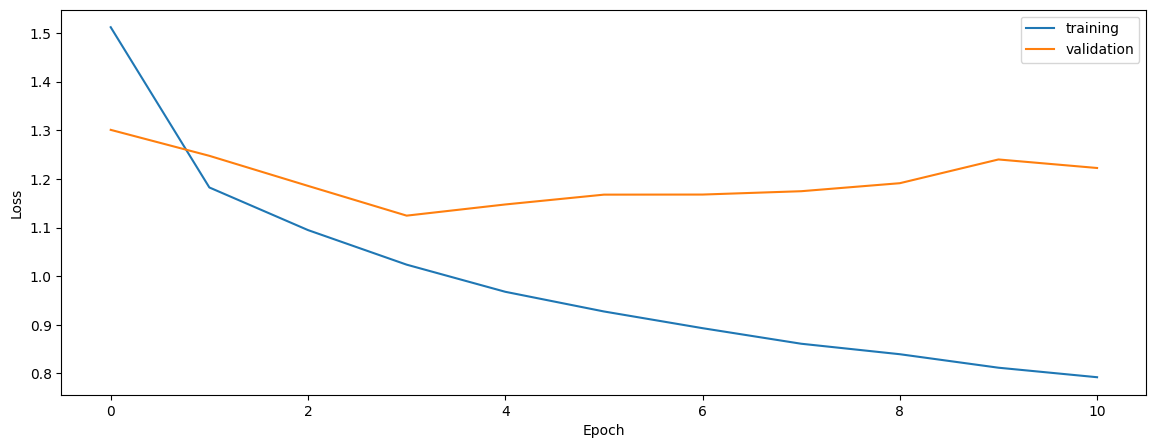

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6153252685053714
0.5489681285648219
0.6146352633612732


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized


0.5061923745698984
0.46933152407662027
0.4544542055363845


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.5018265779537074
0.4777297859240269
0.4500894090491661


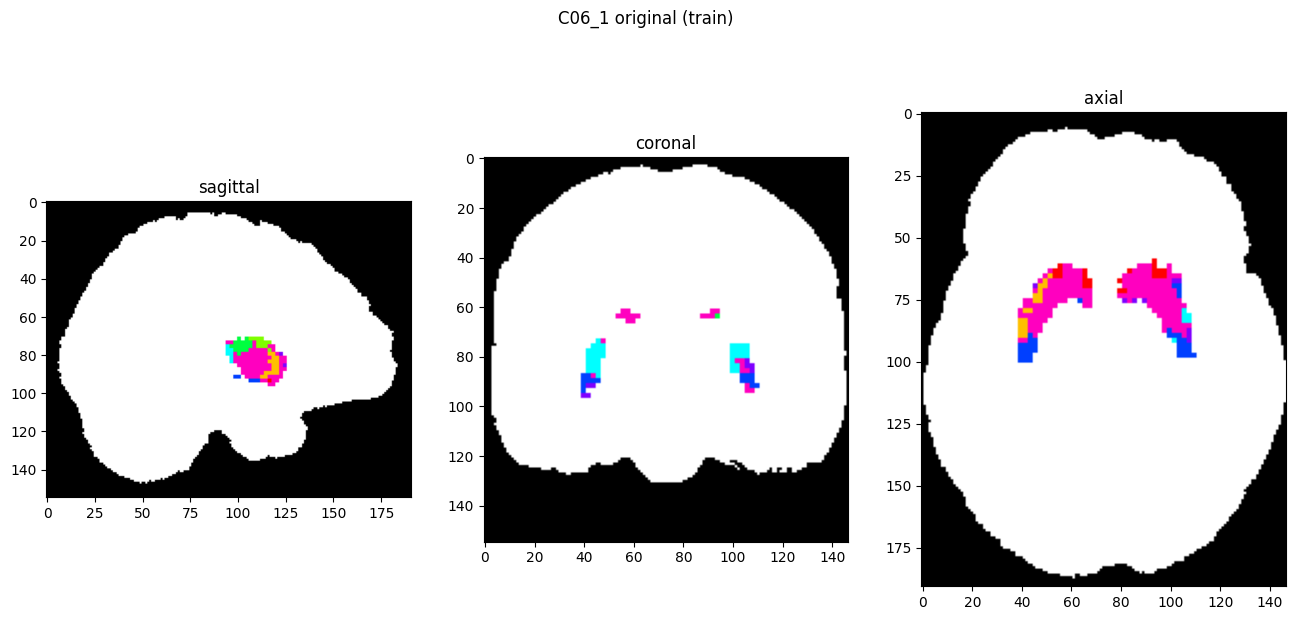

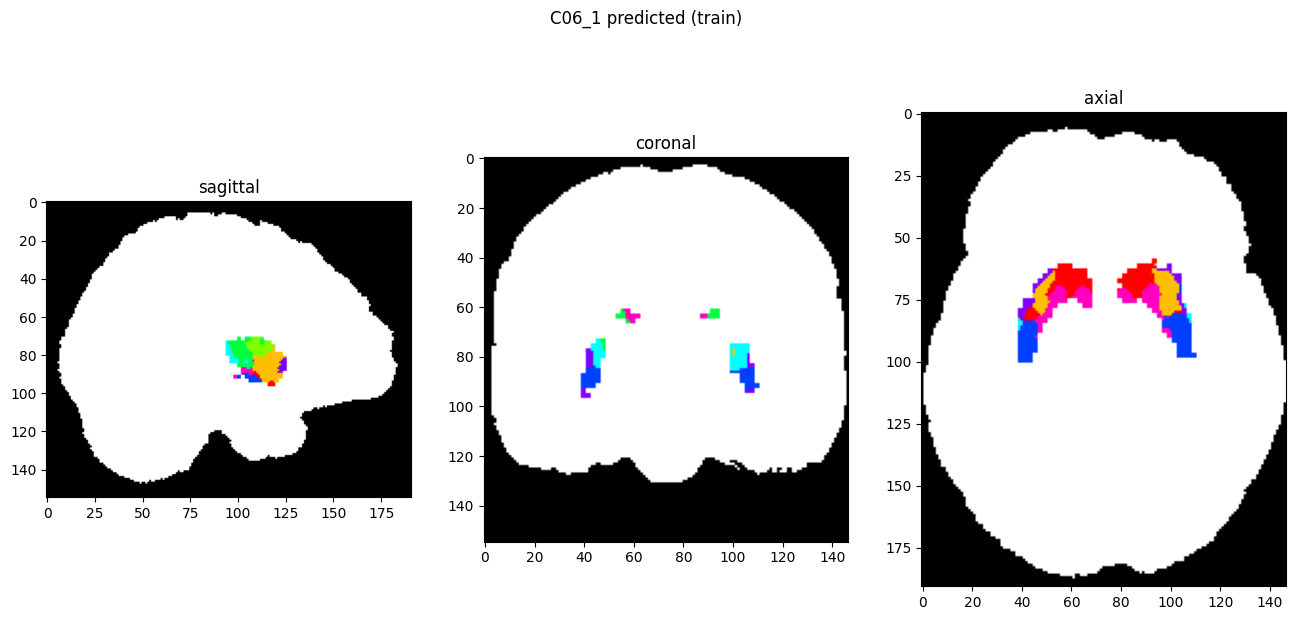

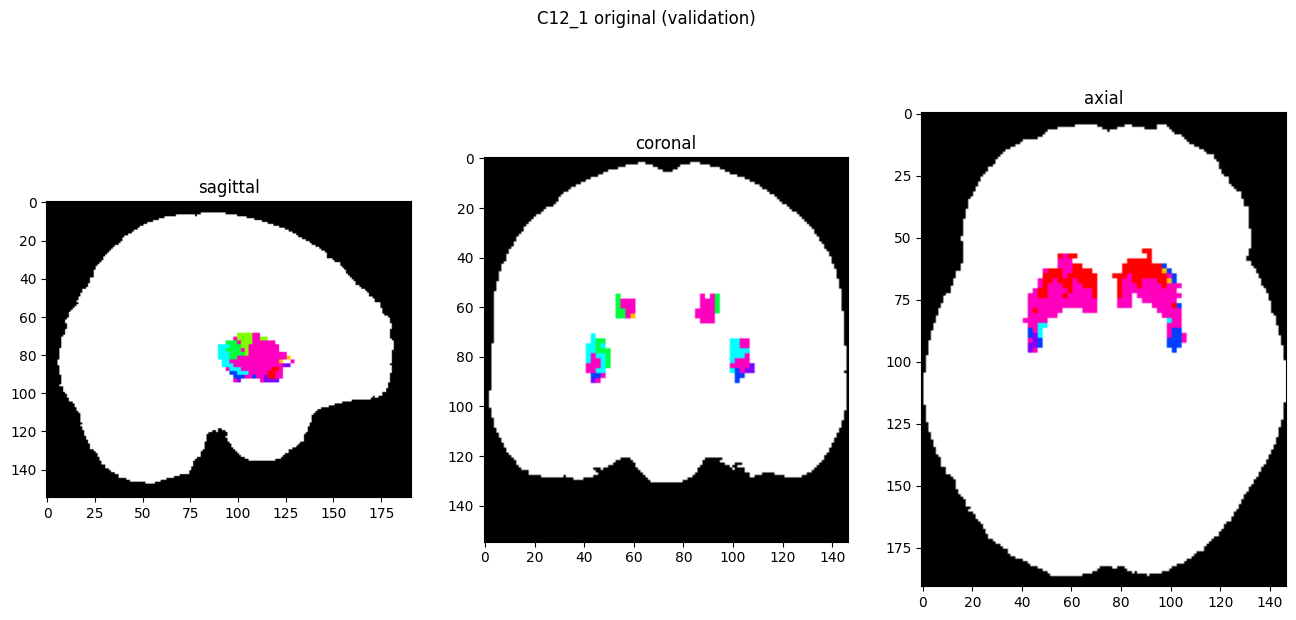

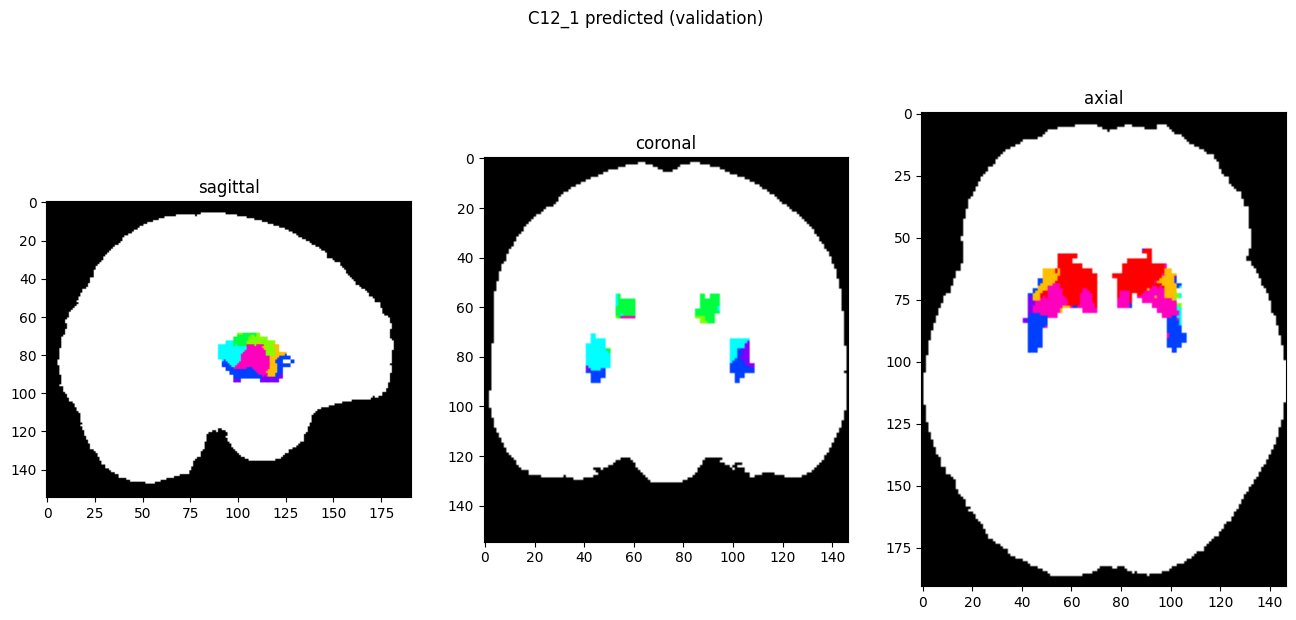

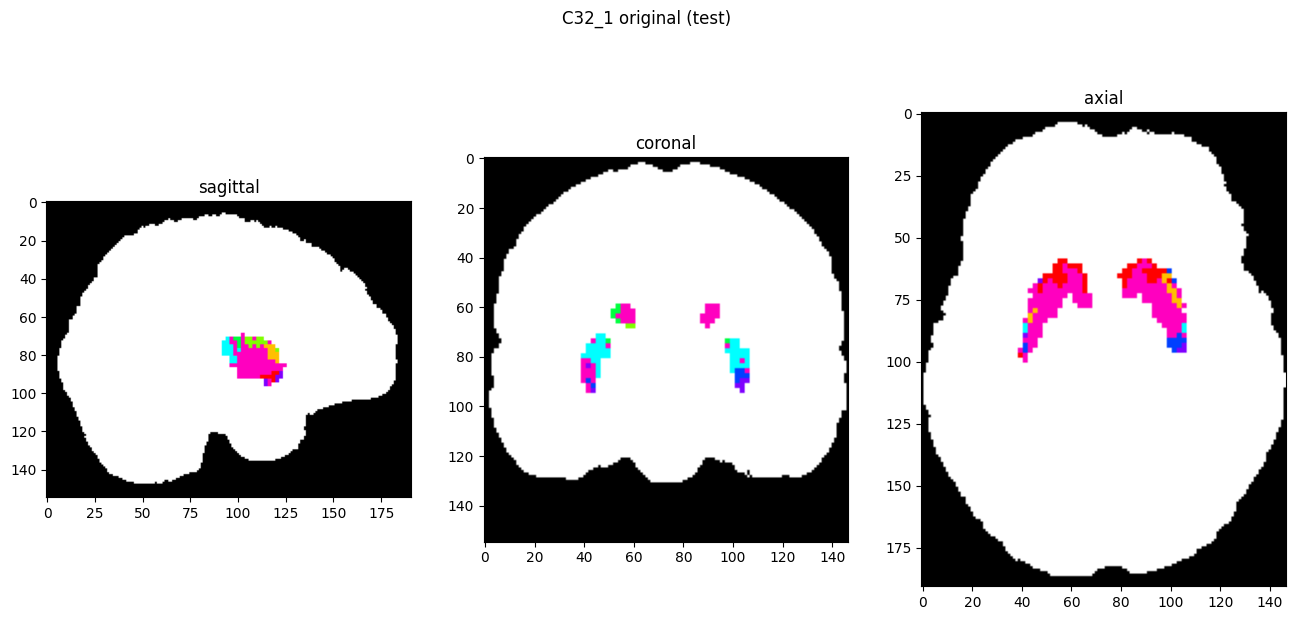

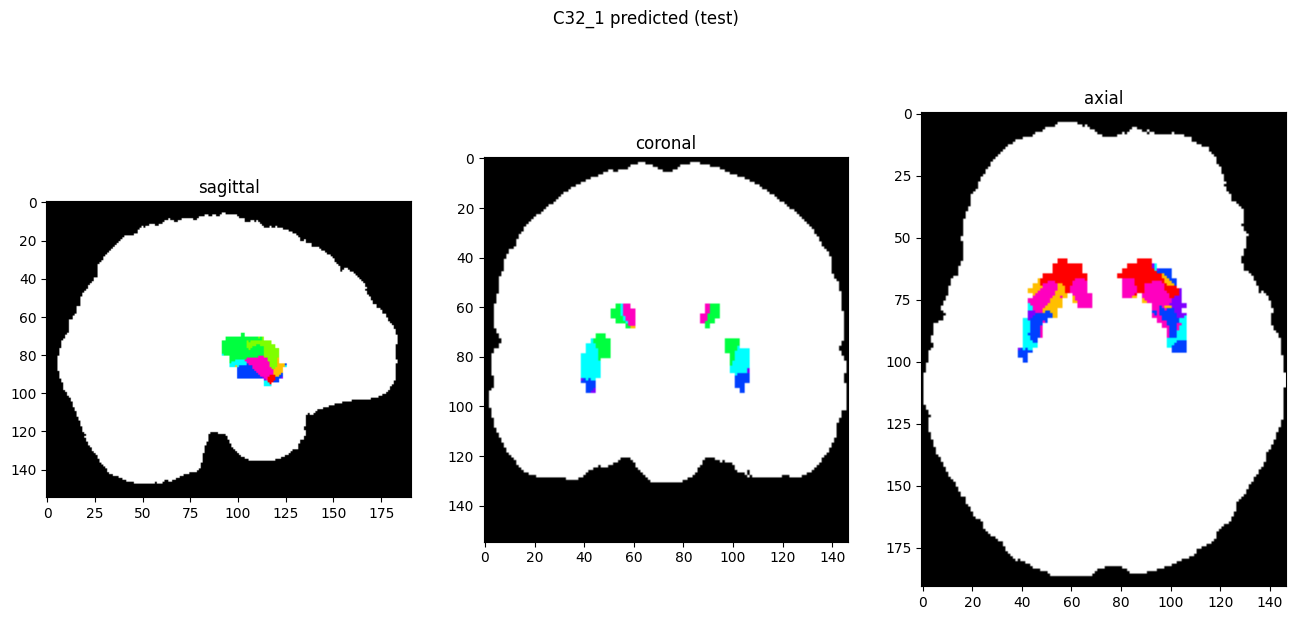

In [10]:
showResults(model, gen, threshold=0)